In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns
yf.pdr_override()

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Regularization
from sklearn.linear_model import Lasso #because we are selecting features.
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor #worst performer because there is no pruning?

# ENSEMBLE

## Bagging (bootstrap aggregation) #likely to overfit too because its underlying uses decision tree 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


# for cross-validation
from sklearn.model_selection import cross_val_score #perf, mean, variance and std error
from sklearn.model_selection import KFold # we can tune it as hyperparameter
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

#import dependency for time series modelling

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix #plot of correlation matrix and kernel density plotting

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler


# FEATURES

In [3]:
capital = 1e5
start_date = dt.datetime(2004,11,1)
end_date = dt.datetime(2023,11,1)

spy = pdr.get_data_yahoo("SPY", start = start_date, end = end_date)
Y = np.log(spy["Adj Close"]).diff(1).shift(-1)
Y.name = "Y_pred"

tnx_ticker = "^TNX"

tnx_data = yf.download(tnx_ticker, start=start_date, end=end_date)

X0 = np.log(tnx_data["Adj Close"])
X0 = X0.ffill()
X0.name = "10years futures"

vix_ticker = "^VIX"

vix = yf.download(vix_ticker, start=start_date, end=end_date)

X0_1 = np.log(vix["Adj Close"])
X0_1 = X0_1.ffill()
X0_1.name = "vix"

X1 = np.log(spy["Volume"])
X2 =\
(pd.concat([Y.
            diff(i) 
            for i in [3,6,12]], 
                   axis = 1
          )
 #.dropna()
)
X2.columns = ["SPY_3", "SPY_6", "SPY_12"]

X3 =\
(
    pd.concat([X1.shift(i)
               #.diff(i) 
               for i in [3,6,12]],
                      axis =1
             )
)
X3.columns = ["Volume_3", "Volume_6", "Volume_12"]

X =\
(
        pd.concat([X0, X0_1, X1, X2, X3],
                 axis = 1)
)

#no trading signal for the first 12 days
X_traintest = X.iloc[12:]
Y_traintest = Y.iloc[12:]

X_traintest = X_traintest.ffill()


#interpreting Y returns in binary signal
Y_traintest_binary = (Y_traintest > 0).astype(int)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
X_traintest

10years futures       vix     Volume     SPY_3     SPY_6  \
Date                                                                   
2004-11-17         1.421662  2.580974  17.813601 -0.001106  0.000579   
2004-11-18         1.415125  2.563410  17.276683 -0.003994 -0.018759   
2004-11-19         1.434132  2.602690  17.809602 -0.001162 -0.003102   
2004-11-22         1.426716  2.562639  17.441456  0.000176 -0.000929   
2004-11-23         1.431268  2.539237  17.552437  0.013546  0.009552   
...                     ...       ...        ...       ...       ...   
2023-10-25         1.599993  3.005187  18.361177 -0.010312  0.001368   
2023-10-26         1.577947  3.029167  18.561805 -0.012054  0.004282   
2023-10-27         1.577947  3.057298  18.491770  0.026341  0.024249   
2023-10-30         1.584120  2.983153  18.276380  0.018308  0.007995   
2023-10-31         1.584120  2.898119  18.193343  0.018308  0.007995   

              SPY_12   Volume_3   Volume_6  Volume_12  
Date                                                   
2004-11-17  0.000996  17.833401  17.614546  17.418857  
2004-11-18 -0.023694  17.379334  17.628054  17.844605  
2004-11-19 -0.008804  17.505107  17.449490  18.158799  
2004-11-22 -0.004719  17.813601  17.833401  17.829193  
2004-11-23  0.003817  17.276683  17.379334  17.963194  
...              ...        ...        ...        ...  
2023-10-25 -0.017238  18.634548  18.137319  18.202206  
2023-10-26 -0.008631  18.337681  18.354111  18.179975  
2023-10-27  0.018000  18.179427  18.613967  17.949904  
2023-10-30  0.011254  18.361177  18.634548  18.211862  
2023-10-31  0.011254  18.561805  18.337681  18.370893  

[4771 rows x 9 columns]

In [5]:
X_traintest.describe()

10years futures          vix       Volume        SPY_3        SPY_6  \
count      4771.000000  4771.000000  4771.000000  4771.000000  4771.000000   
mean          0.949562     2.884216    18.485200     0.000006    -0.000003   
std           0.449800     0.374347     0.594471     0.017087     0.017530   
min          -0.695149     2.212660    16.541401    -0.133988    -0.165887   
25%           0.676255     2.590767    18.038105    -0.007521    -0.007547   
50%           0.982453     2.826722    18.408187    -0.000337    -0.000367   
75%           1.307522     3.115513    18.886602     0.007141     0.007140   
max           1.657847     4.415099    20.585183     0.161981     0.202617   

            SPY_12     Volume_3     Volume_6    Volume_12  
count  4771.000000  4771.000000  4771.000000  4771.000000  
mean     -0.000014    18.484730    18.484225    18.483457  
std       0.017018     0.594907     0.595339     0.595927  
min      -0.142856    16.541401    16.541401    16.541401  
25%      -0.007762    18.036886    18.035614    18.033281  
50%      -0.000342    18.407938    18.407802    18.405829  
75%       0.007185    18.886602    18.886602    18.886602  
max       0.135072    20.585183    20.585183    20.585183

In [6]:
Y_traintest

Date
2004-11-17    0.001348
2004-11-18   -0.011179
2004-11-19    0.004758
2004-11-22    0.001525
2004-11-23    0.002367
                ...   
2023-10-25   -0.012047
2023-10-26   -0.004543
2023-10-27    0.011885
2023-10-30    0.006261
2023-10-31         NaN
Name: Y_pred, Length: 4771, dtype: float64

In [7]:
X_traintest.isna().any()

10years futures    False
vix                False
Volume             False
SPY_3              False
SPY_6              False
SPY_12             False
Volume_3           False
Volume_6           False
Volume_12          False
dtype: bool

In [8]:
 Y_traintest.shift(-1)

Date
2004-11-17   -0.011179
2004-11-18    0.004758
2004-11-19    0.001525
2004-11-22    0.002367
2004-11-23   -0.000760
                ...   
2023-10-25   -0.004543
2023-10-26    0.011885
2023-10-27    0.006261
2023-10-30         NaN
2023-10-31         NaN
Name: Y_pred, Length: 4771, dtype: float64

In [9]:
# Engineering more features
# Uses F-statistics to determine model significance

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)

index_ = Y_traintest.shift(-1).dropna().index 

X_poly = poly.fit_transform(X_traintest.loc[index_])


from sklearn.feature_selection import SelectKBest, f_regression
#(R-squared / (1 - R-squared)) * ((n - k - 1) / k)

selector = SelectKBest(score_func=f_regression, k=10) #marginal improvement from when k = 8. big improvement from k = 5

#we are shifting the Y values because we need to train the model for a 1 day look ahead
X_selected = selector.fit_transform(X_poly, Y_traintest.shift(-1).loc[index_]) #Y_traintest_binary

X_selected

array([[ 1.49382314e-03,  3.85551887e-03,  2.66103697e-02, ...,
         1.83865997e-01,  1.81609565e-01,  1.84070360e-01],
       [-4.80875714e-02, -1.23268146e-01, -8.30793725e-01, ...,
        -5.63259232e+00, -5.71320159e+00, -5.66605891e+00],
       [-8.07238166e-03, -2.10099045e-02, -1.43765904e-01, ...,
        -9.66937235e-01, -9.63865092e-01, -9.50405297e-01],
       ...,
       [ 4.11037386e-03,  1.23524440e-02,  7.54713019e-02, ...,
         4.67981982e-01,  4.55494731e-01,  4.74949542e-01],
       [ 1.29713649e-02,  3.92924314e-02,  2.40771949e-01, ...,
         1.45756210e+00,  1.45886809e+00,  1.43996275e+00],
       [ 7.41365621e-02,  2.26657537e-01,  1.37091625e+00, ...,
         8.15179755e+00,  8.34664882e+00,  8.01410607e+00]])

In [10]:
#get the features name used. Volume could be a cross-product or of a higher power

X_columns = selector.get_feature_names_out()

In [11]:
X_columns

array(['x22', 'x103', 'x110', 'x123', 'x124', 'x125', 'x138', 'x151',
       'x152', 'x194'], dtype=object)

In [12]:
X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = X_traintest.iloc[:-2].index)

In [13]:
X_selected_df

x22      x103      x110      x123      x124      x125  \
Date                                                                     
2004-11-17  0.001494  0.003856  0.026610  0.026640  0.026313  0.026021   
2004-11-18 -0.048088 -0.123268 -0.830794 -0.835730 -0.847690 -0.858104   
2004-11-19 -0.008072 -0.021010 -0.143766 -0.141308 -0.140859 -0.146585   
2004-11-22 -0.002382 -0.006103 -0.041539 -0.042426 -0.042473 -0.042463   
2004-11-23  0.024254  0.061587  0.425722  0.419033  0.421523  0.435684   
...              ...       ...       ...       ...       ...       ...   
2023-10-23 -0.008908 -0.026848 -0.163346 -0.163493 -0.163642 -0.160927   
2023-10-24 -0.042407 -0.124799 -0.770942 -0.789369 -0.769217 -0.786432   
2023-10-25  0.004110  0.012352  0.075471  0.076595  0.074551  0.074818   
2023-10-26  0.012971  0.039292  0.240772  0.237865  0.238078  0.235819   
2023-10-27  0.074137  0.226658  1.370916  1.347760  1.379976  1.330744   

                x138      x151      x152      x194  
Date                                                
2004-11-17  0.183662  0.183866  0.181610  0.184070  
2004-11-18 -5.599323 -5.632592 -5.713202 -5.666059  
2004-11-19 -0.983757 -0.966937 -0.963865 -0.950405  
2004-11-22 -0.282718 -0.288751 -0.289072 -0.294912  
2004-11-23  2.942794  2.896562  2.913772  2.851056  
...              ...       ...       ...       ...  
2023-10-23 -0.993806 -0.994697 -0.995606 -0.995588  
2023-10-24 -4.762470 -4.876307 -4.751816 -4.992864  
2023-10-25  0.461117  0.467982  0.455495  0.474950  
2023-10-26  1.475377  1.457562  1.458868  1.439963  
2023-10-27  8.291855  8.151798  8.346649  8.014106  

[4769 rows x 10 columns]

In [14]:
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso

#between 0 to 1 where 0 is Ridge and 1 is Lasso
penalty_ = 0.0

#linear_regression2 = LinearRegression()
elastic_net = ElasticNet(alpha=0.1, l1_ratio=penalty_)
#ridge_model = Ridge(alpha=1.0)
index_ = X_selected_df.index
elastic_net.fit(X_selected_df, Y_traintest.shift(-1).loc[index_])
print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

EN_pred_train2 = elastic_net.predict(X_selected_df)
print(EN_pred_train2)

#continuous predictions are turned into binary signal or 1 and 0 

Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)
Y_pred_binary2

logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
logreg_sk2.fit(X_selected_df, Y_pred_binary2)
print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))

Y_pred_logistic2 = logreg_sk2.predict(X_selected_df)

print("Name of features used: {}".format(elastic_net.feature_names_in_))
print(" ")
print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.iloc[:-2], Y_pred_logistic2))
print(" ")
print("Precision :", metrics.precision_score(Y_traintest_binary.iloc[:-2],Y_pred_logistic2))
print(" ")
print("Recall :", metrics.recall_score(Y_traintest_binary.iloc[:-2],Y_pred_logistic2)) 

intercept is 0.000 and coefficients are [-4.73592173e-05 -3.97501273e-04 -1.03019999e-03 -9.85717352e-04
 -8.74256838e-04 -6.95349140e-04 -3.12334315e-04 -1.47604462e-05
  5.85936438e-04  1.91628839e-04]
[ 0.00035935  0.0008415   0.00046997 ...  0.00030553  0.00015167
 -0.00087592]
intercept is 2.919 and coefficients are [-0.00772637 -0.04718596 -0.16482106 -0.16253932 -0.16045765 -0.16194323
 -0.19884151 -0.18435913 -0.1734253  -0.17040437]
Name of features used: ['x22' 'x103' 'x110' 'x123' 'x124' 'x125' 'x138' 'x151' 'x152' 'x194']
 
Accuracy : 0.4109876284336339
 
Precision : 0.4744150167138082
 
Recall : 0.7068965517241379


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.477e-01, tolerance: 7.079e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
Y_pred_logistic2.shape

(4769,)

In [16]:
Y_traintest_binary.iloc[:-2]

Date
2004-11-17    1
2004-11-18    0
2004-11-19    1
2004-11-22    1
2004-11-23    1
             ..
2023-10-23    1
2023-10-24    0
2023-10-25    0
2023-10-26    0
2023-10-27    1
Name: Y_pred, Length: 4769, dtype: int64

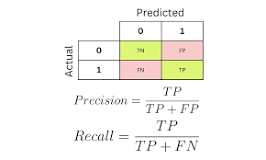

[Text(0.5, 0, 'predicted values'),
 Text(0, 0.5, 'target values'),
 Text(0.5, 1.0, 'Predicted vs Actual Responses')]

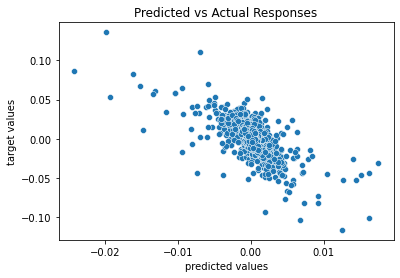

In [17]:
#linear correlation is expected of a plot between in-sample test and y_pred 

ax = sns.scatterplot(x=EN_pred_train2, y= Y_traintest.iloc[:-2])
ax.set(xlabel='predicted values', ylabel='target values',title="Predicted vs Actual Responses")

In [18]:
#notice that this shape is unconventional. it should have a gradient of +1 and it is showing -1 now.

In [19]:
Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = X_selected_df.index)

In [20]:
X_selected_df

x22      x103      x110      x123      x124      x125  \
Date                                                                     
2004-11-17  0.001494  0.003856  0.026610  0.026640  0.026313  0.026021   
2004-11-18 -0.048088 -0.123268 -0.830794 -0.835730 -0.847690 -0.858104   
2004-11-19 -0.008072 -0.021010 -0.143766 -0.141308 -0.140859 -0.146585   
2004-11-22 -0.002382 -0.006103 -0.041539 -0.042426 -0.042473 -0.042463   
2004-11-23  0.024254  0.061587  0.425722  0.419033  0.421523  0.435684   
...              ...       ...       ...       ...       ...       ...   
2023-10-23 -0.008908 -0.026848 -0.163346 -0.163493 -0.163642 -0.160927   
2023-10-24 -0.042407 -0.124799 -0.770942 -0.789369 -0.769217 -0.786432   
2023-10-25  0.004110  0.012352  0.075471  0.076595  0.074551  0.074818   
2023-10-26  0.012971  0.039292  0.240772  0.237865  0.238078  0.235819   
2023-10-27  0.074137  0.226658  1.370916  1.347760  1.379976  1.330744   

                x138      x151      x152      x194  
Date                                                
2004-11-17  0.183662  0.183866  0.181610  0.184070  
2004-11-18 -5.599323 -5.632592 -5.713202 -5.666059  
2004-11-19 -0.983757 -0.966937 -0.963865 -0.950405  
2004-11-22 -0.282718 -0.288751 -0.289072 -0.294912  
2004-11-23  2.942794  2.896562  2.913772  2.851056  
...              ...       ...       ...       ...  
2023-10-23 -0.993806 -0.994697 -0.995606 -0.995588  
2023-10-24 -4.762470 -4.876307 -4.751816 -4.992864  
2023-10-25  0.461117  0.467982  0.455495  0.474950  
2023-10-26  1.475377  1.457562  1.458868  1.439963  
2023-10-27  8.291855  8.151798  8.346649  8.014106  

[4769 rows x 10 columns]

In [21]:
X_traintest3 = X.copy()
X_traintest3["signal"] = Y_pred_logistic2_df
X_traintest3["signal"].iloc[:13] = 0

In [22]:
X_traintest3["signal"]

Date
2004-11-01    0.0
2004-11-02    0.0
2004-11-03    0.0
2004-11-04    0.0
2004-11-05    0.0
             ... 
2023-10-25    1.0
2023-10-26    1.0
2023-10-27    0.0
2023-10-30    NaN
2023-10-31    NaN
Name: signal, Length: 4783, dtype: float64

In [23]:
X_traintest3

10years futures       vix     Volume     SPY_3     SPY_6  \
Date                                                                   
2004-11-01         1.408545  2.789323  17.418857       NaN       NaN   
2004-11-02         1.404871  2.783776  17.844605       NaN       NaN   
2004-11-03         1.403643  2.641910  18.158799       NaN       NaN   
2004-11-04         1.403151  2.636912  17.829193  0.005891       NaN   
2004-11-05         1.431746  2.627563  17.963194 -0.013965       NaN   
...                     ...       ...        ...       ...       ...   
2023-10-25         1.599993  3.005187  18.361177 -0.010312  0.001368   
2023-10-26         1.577947  3.029167  18.561805 -0.012054  0.004282   
2023-10-27         1.577947  3.057298  18.491770  0.026341  0.024249   
2023-10-30         1.584120  2.983153  18.276380  0.018308  0.007995   
2023-10-31         1.584120  2.898119  18.193343       NaN       NaN   

              SPY_12   Volume_3   Volume_6  Volume_12  signal  
Date                                                           
2004-11-01       NaN        NaN        NaN        NaN     0.0  
2004-11-02       NaN        NaN        NaN        NaN     0.0  
2004-11-03       NaN        NaN        NaN        NaN     0.0  
2004-11-04       NaN  17.418857        NaN        NaN     0.0  
2004-11-05       NaN  17.844605        NaN        NaN     0.0  
...              ...        ...        ...        ...     ...  
2023-10-25 -0.017238  18.634548  18.137319  18.202206     1.0  
2023-10-26 -0.008631  18.337681  18.354111  18.179975     1.0  
2023-10-27  0.018000  18.179427  18.613967  17.949904     0.0  
2023-10-30  0.011254  18.361177  18.634548  18.211862     NaN  
2023-10-31       NaN  18.561805  18.337681  18.370893     NaN  

[4783 rows x 10 columns]

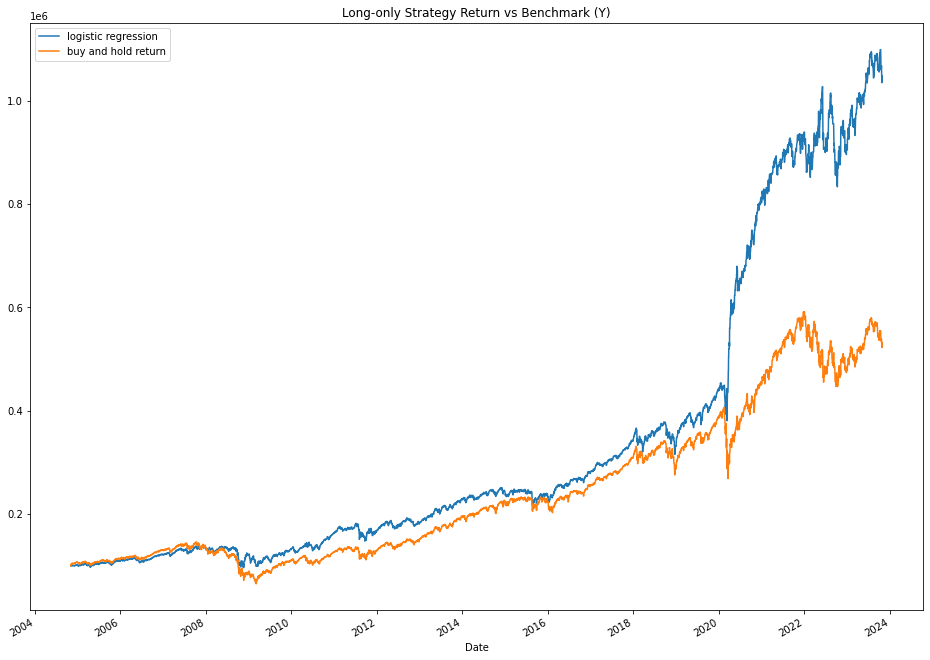

In [24]:
X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])
#((X_traintest3["strategy_return"] + 1).cumprod() * capital).plot(ax=ax, label = "logistic regression")
(X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")
#((1+Y).cumprod() * capital).plot(ax=ax, label = "simple return")
(Y.cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

# Add legend
ax.legend()

# Add title
ax.set_title('Long-only Strategy Return vs Benchmark (Y)')

# Show the plot
plt.show()
#capital * (1 + X_traintest3["strategy_return"]).cumprod().plot(figsize=[16,12])

In [25]:
cumu_ret = X_traintest3["strategy_return"].cumsum().apply(np.exp).iloc[-4]

In [26]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25    10.394924
2023-10-26    10.347806
2023-10-27    10.471523
2023-10-30    10.471523
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

In [27]:
cumu_ret

10.347806427173078

In [28]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25    10.394924
2023-10-26    10.347806
2023-10-27    10.471523
2023-10-30    10.471523
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

In [29]:
X_traintest3["signal"].value_counts()

signal
1.0    3888
0.0     893
Name: count, dtype: int64

In [30]:
#what if we can short?

In [31]:
signal = X_traintest3["signal"].copy()
short_signal = (signal == 0) * -1 
signals = short_signal + signal

signals.iloc[:12] = 0
signals.value_counts()
#X_traintest3["signal"].iloc[:12] = 0
#X_traintest3["signal"].value_counts()


signal
 1.0    3888
-1.0     881
 0.0      12
Name: count, dtype: int64

In [32]:
X_traintest3_copy = X_traintest3.copy()
X_traintest3_copy["signal"] = signals

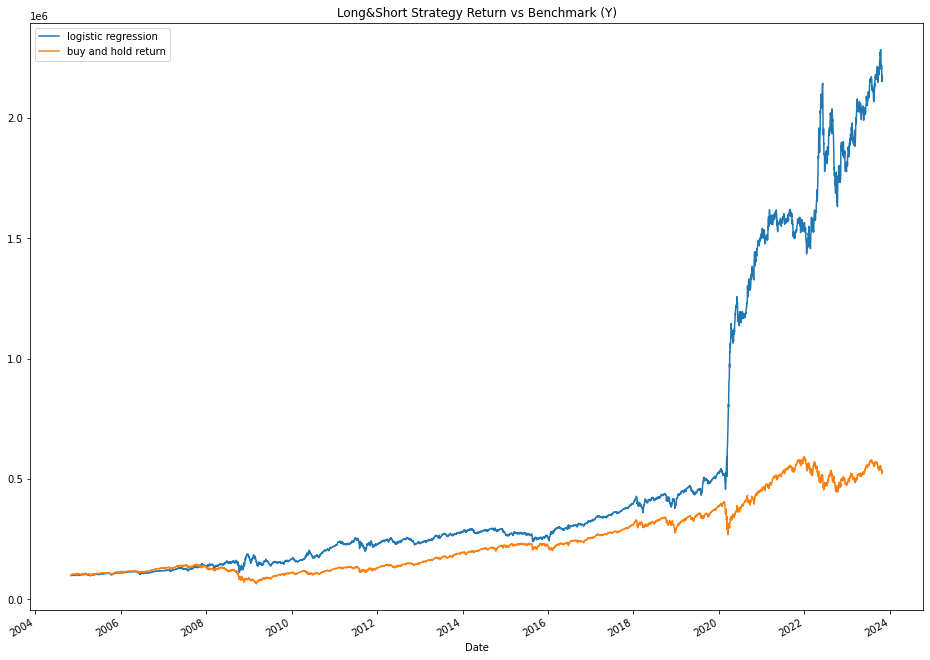

In [33]:
X_traintest3["strategy_return"] = X_traintest3_copy["signal"].shift(1) * Y

fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

(X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

(Y.cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

# Add legend
ax.legend()

# Add title
ax.set_title('Long&Short Strategy Return vs Benchmark (Y)')

# Show the plot
plt.show()


In [34]:
#cumu_ret_w_short = ((X_traintest3["strategy_return"] + 1).cumprod() * capital).iloc[-3]

In [35]:
cumu_ret_w_short = X_traintest3["strategy_return"].cumsum().apply(np.exp).iloc[-4]
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25    21.604077
2023-10-26    21.506151
2023-10-27    21.763274
2023-10-30    21.627448
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

In [36]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25    21.604077
2023-10-26    21.506151
2023-10-27    21.763274
2023-10-30    21.627448
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

In [37]:
cumu_ret_w_short

21.506150743236297

In [38]:
(cumu_ret_w_short - cumu_ret)/ max(cumu_ret_w_short, cumu_ret)

0.5188443273407506

In [39]:
(cumu_ret_w_short - cumu_ret)/ cumu_ret

1.0783294406012167

# with optimization of the decision threshold value and best k of feature engineering and alpha in elastic net

In [40]:
X_traintest

10years futures       vix     Volume     SPY_3     SPY_6  \
Date                                                                   
2004-11-17         1.421662  2.580974  17.813601 -0.001106  0.000579   
2004-11-18         1.415125  2.563410  17.276683 -0.003994 -0.018759   
2004-11-19         1.434132  2.602690  17.809602 -0.001162 -0.003102   
2004-11-22         1.426716  2.562639  17.441456  0.000176 -0.000929   
2004-11-23         1.431268  2.539237  17.552437  0.013546  0.009552   
...                     ...       ...        ...       ...       ...   
2023-10-25         1.599993  3.005187  18.361177 -0.010312  0.001368   
2023-10-26         1.577947  3.029167  18.561805 -0.012054  0.004282   
2023-10-27         1.577947  3.057298  18.491770  0.026341  0.024249   
2023-10-30         1.584120  2.983153  18.276380  0.018308  0.007995   
2023-10-31         1.584120  2.898119  18.193343  0.018308  0.007995   

              SPY_12   Volume_3   Volume_6  Volume_12  
Date                                                   
2004-11-17  0.000996  17.833401  17.614546  17.418857  
2004-11-18 -0.023694  17.379334  17.628054  17.844605  
2004-11-19 -0.008804  17.505107  17.449490  18.158799  
2004-11-22 -0.004719  17.813601  17.833401  17.829193  
2004-11-23  0.003817  17.276683  17.379334  17.963194  
...              ...        ...        ...        ...  
2023-10-25 -0.017238  18.634548  18.137319  18.202206  
2023-10-26 -0.008631  18.337681  18.354111  18.179975  
2023-10-27  0.018000  18.179427  18.613967  17.949904  
2023-10-30  0.011254  18.361177  18.634548  18.211862  
2023-10-31  0.011254  18.561805  18.337681  18.370893  

[4771 rows x 9 columns]

In [41]:
#transform X_selected into dataframe

X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = X_traintest.iloc[:-2].index)
X_selected_df

x22      x103      x110      x123      x124      x125  \
Date                                                                     
2004-11-17  0.001494  0.003856  0.026610  0.026640  0.026313  0.026021   
2004-11-18 -0.048088 -0.123268 -0.830794 -0.835730 -0.847690 -0.858104   
2004-11-19 -0.008072 -0.021010 -0.143766 -0.141308 -0.140859 -0.146585   
2004-11-22 -0.002382 -0.006103 -0.041539 -0.042426 -0.042473 -0.042463   
2004-11-23  0.024254  0.061587  0.425722  0.419033  0.421523  0.435684   
...              ...       ...       ...       ...       ...       ...   
2023-10-23 -0.008908 -0.026848 -0.163346 -0.163493 -0.163642 -0.160927   
2023-10-24 -0.042407 -0.124799 -0.770942 -0.789369 -0.769217 -0.786432   
2023-10-25  0.004110  0.012352  0.075471  0.076595  0.074551  0.074818   
2023-10-26  0.012971  0.039292  0.240772  0.237865  0.238078  0.235819   
2023-10-27  0.074137  0.226658  1.370916  1.347760  1.379976  1.330744   

                x138      x151      x152      x194  
Date                                                
2004-11-17  0.183662  0.183866  0.181610  0.184070  
2004-11-18 -5.599323 -5.632592 -5.713202 -5.666059  
2004-11-19 -0.983757 -0.966937 -0.963865 -0.950405  
2004-11-22 -0.282718 -0.288751 -0.289072 -0.294912  
2004-11-23  2.942794  2.896562  2.913772  2.851056  
...              ...       ...       ...       ...  
2023-10-23 -0.993806 -0.994697 -0.995606 -0.995588  
2023-10-24 -4.762470 -4.876307 -4.751816 -4.992864  
2023-10-25  0.461117  0.467982  0.455495  0.474950  
2023-10-26  1.475377  1.457562  1.458868  1.439963  
2023-10-27  8.291855  8.151798  8.346649  8.014106  

[4769 rows x 10 columns]

# need to perform optimization of k 

In [84]:
#Feature Engineering

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression


"""
optimize k with mse of linear regression
to do that, i need to turn this into a function
inputs that i need are : X_traintest, Y_traintest, years_in_data, k_ = "all"

if k_ != "all":
    k_ = "all"
"""

#initiate dictionary to hold data from df.loc[:year]
df_dict = {}

years_in_data = pd.unique(X_traintest.index.year)

def get_feature_engr(X_traintest, Y_traintest, years_in_data, *args):
    
    k_ = args[0] if args else "all"
    
    for year_ in years_in_data:
        mask =\
        (X_traintest
         .columns[
                     X_traintest
                    .apply(lambda col: col.loc[X_traintest.index.year == year_].isna().mean() < 0.3)
                 ]
        )

        X_traintest_to_year = X_traintest.loc[:str(year_), mask].copy()

        #Feature scaling, consideration of not removing mean so that the values wont go into negative

        X_traintest_to_year =\
        (
            X_traintest_to_year
            /
            X_traintest_to_year.max()
        )

        Y_traintest_to_year = Y_traintest.loc[:str(year_)]

        poly = PolynomialFeatures(degree=3)

        #we are shifting the Y values because we need to train the model for a 1 day look ahead
        index_ =\
        (Y_traintest_to_year
         .shift(-1)
         .dropna()
         .index 
        )

        X_poly = poly.fit_transform(X_traintest_to_year.loc[index_])  
        #(R-squared / (1 - R-squared)) * ((n - unrestricted k - 1) / m), m is total number of unrestricted parameters-1

        selector = SelectKBest(score_func=f_regression, k=10) 

        X_selected = selector.fit_transform(X_poly, Y_traintest.shift(-1).loc[index_]) #Y_traintest_binary

        X_columns = selector.get_feature_names_out()

        #transform X_selected into dataframe
        X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)

        #make sure no missing values
        X_selected_df = X_selected_df.ffill()

        #columns = X_selected_df.columns 

        df_dict[year_] = X_selected_df
        
    return df_dict #X_columns can be retrieved from df_dict[year].columns

# analysis: we did feature scaling of z score, use polynomial featuring to overfit and use f-statistics to determine the top variables. Optimization will render this parameter data-centric and it won't require any human input. this leverages on the strength of automation and allowing data to decide the ideal paramter, based on MSE score.

In [85]:
df_dict = get_feature_engr(X_traintest, Y_traintest, years_in_data)

In [86]:
df_dict[2005]

x20       x26      x101      x107      x112      x114  \
Date                                                                     
2004-11-17  0.852023  0.833142  0.764668  0.747723  0.809773  0.790950   
2004-11-18  0.820719  0.847697  0.731561  0.755609  0.760160  0.780511   
2004-11-19  0.858999  0.875841  0.777415  0.792658  0.801374  0.831299   
2004-11-22  0.828297  0.846711  0.738094  0.754502  0.786350  0.787038   
2004-11-23  0.825955  0.845284  0.729286  0.746352  0.760492  0.790711   
...              ...       ...       ...       ...       ...       ...   
2005-12-22  0.746894  0.772205  0.605441  0.625957  0.704622  0.711507   
2005-12-23  0.740139  0.777716  0.599464  0.629899  0.696486  0.710698   
2005-12-27  0.799070  0.814561  0.680312  0.693501  0.756449  0.764514   
2005-12-28  0.776187  0.798716  0.655648  0.674679  0.715177  0.733930   
2005-12-29  0.786320  0.804004  0.670400  0.685478  0.718560  0.741520   

                x132      x135          x164      x165  
Date                                                    
2004-11-17  0.791829  0.773422 -8.832107e-05  0.000036  
2004-11-18  0.785149  0.806168 -4.164245e-03 -0.015143  
2004-11-19  0.817086  0.847599 -1.025805e-04 -0.000212  
2004-11-22  0.803831  0.804534  3.581243e-07 -0.000001  
2004-11-23  0.778289  0.809215  1.624149e-01  0.088676  
...              ...       ...           ...       ...  
2005-12-22  0.728500  0.735618 -4.248270e-06  0.000028  
2005-12-23  0.731847  0.746780 -1.078118e-01 -0.049486  
2005-12-27  0.771114  0.779336 -1.754031e-03  0.003350  
2005-12-28  0.735935  0.755233 -8.242670e-03 -0.006894  
2005-12-29  0.734720  0.758197  7.144235e-03 -0.008138  

[282 rows x 10 columns]

In [87]:
# Model Specification

penalty_ = 0.0

def fit_and_predict(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        elastic_net = ElasticNet(alpha=0.01, l1_ratio=penalty_) #alpha is set lower here than above to reduce penalty

        elastic_net.fit(df_dict[year_], Y_traintest_series_fraction)
        print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

        EN_pred_train2 = elastic_net.predict(df_dict[year_])


        #continuous predictions are turned into binary signal or 1 and 0 
        Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)


        logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
        logreg_sk2.fit(df_dict[year_], Y_pred_binary2)
        print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))
        

        Y_pred_logistic2 = logreg_sk2.predict(df_dict[year_])

        Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = df_dict[year_].index)

        params_dict[f"EN_pred_{year_}"] = EN_pred_train2
        params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
        params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

        params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
        params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
        params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
        print("Name of features used: {}".format(elastic_net.feature_names_in_))
        print(" ")
        print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
        print(" ")
        print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        print(" ")
        print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        
        #long only    
        
        X_traintest3 = X.copy()
        X_traintest3["signal"] = Y_pred_logistic2_df
        X_traintest3["signal"].iloc[:12] = 0

        X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Long-only Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e-04, tolerance: 6.961e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is -0.002 and coefficients are [ 2.38569671e-03  7.73573829e-05  3.63084957e-04 -8.39533593e-06
  2.60018905e-04  6.33238938e-04  2.52650748e-04  5.00321537e-04
  1.11440365e-04  3.25758888e-04]
intercept is 1.911 and coefficients are [0.05417396 0.7337049  0.71626658 0.73478717 0.73590421 0.69971256
 0.71761784 0.71864475 0.73720964 0.73861979]
Name of features used: ['x78' 'x102' 'x109' 'x118' 'x119' 'x137' 'x146' 'x147' 'x180' 'x182']
 
Accuracy : 0.9
 
Precision : 0.8636363636363636
 
Recall : 1.0


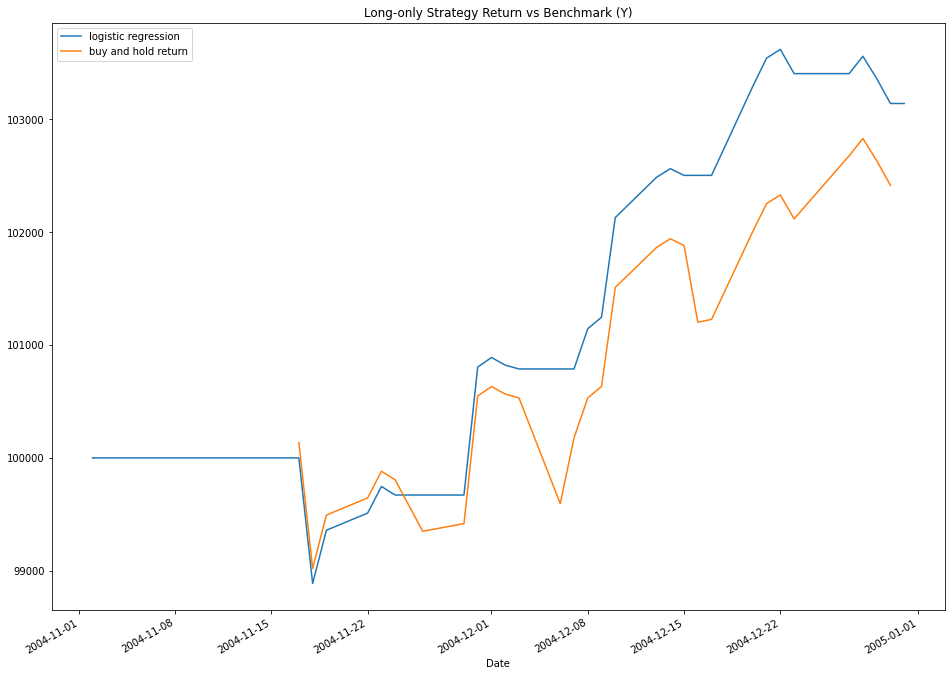

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.662e-03, tolerance: 1.158e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is -0.008 and coefficients are [ 0.00103666  0.00105304  0.00160122  0.00163195  0.00102716  0.00130032
  0.0010544   0.00131711 -0.00262643 -0.00185881]
intercept is -11.771 and coefficients are [ 1.67605322  1.58099718  2.65658832  2.57708675  1.88233705  1.81399248
  1.79581086  1.72237004 -3.23915532 -1.26270515]
Name of features used: ['x20' 'x26' 'x101' 'x107' 'x112' 'x114' 'x132' 'x135' 'x164' 'x165']
 
Accuracy : 0.4645390070921986
 
Precision : 0.5118483412322274
 
Recall : 0.6923076923076923


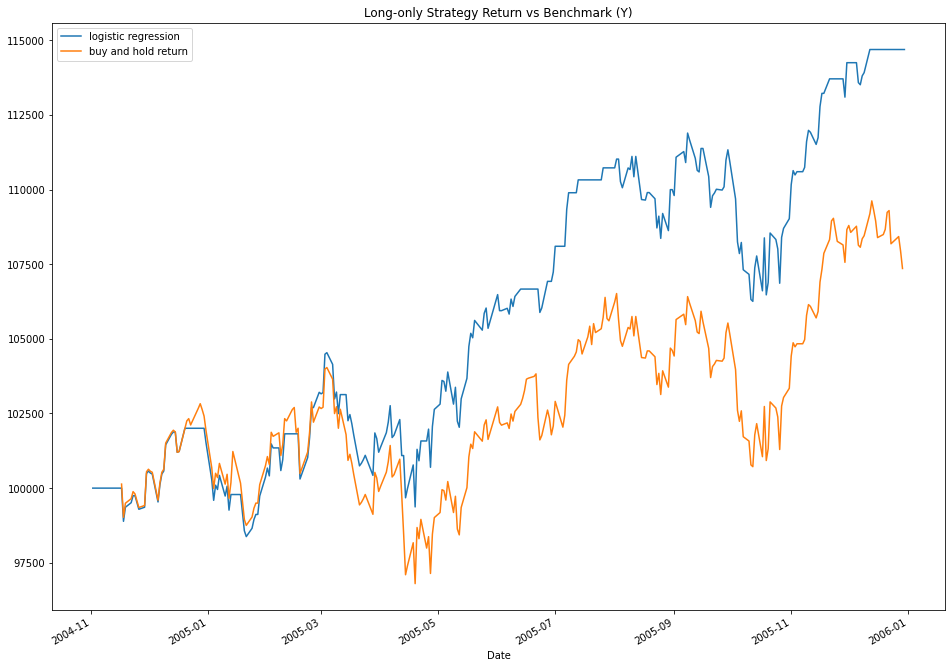

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.046e-02, tolerance: 2.124e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is -0.005 and coefficients are [ 0.00084909  0.0013824   0.00124358  0.00104721  0.0007633   0.00113832
  0.00083346  0.0009374  -0.0032026  -0.00218254]
intercept is -10.686 and coefficients are [ 2.09186639  3.28179081  2.94012613  2.69147715  1.92638464  2.29509309
  1.90082064  1.9921922  -2.85589716 -1.97833274]
Name of features used: ['x24' 'x100' 'x105' 'x107' 'x112' 'x130' 'x131' 'x132' 'x164' 'x166']
 
Accuracy : 0.5459662288930581
 
Precision : 0.5521821631878557
 
Recall : 0.9797979797979798


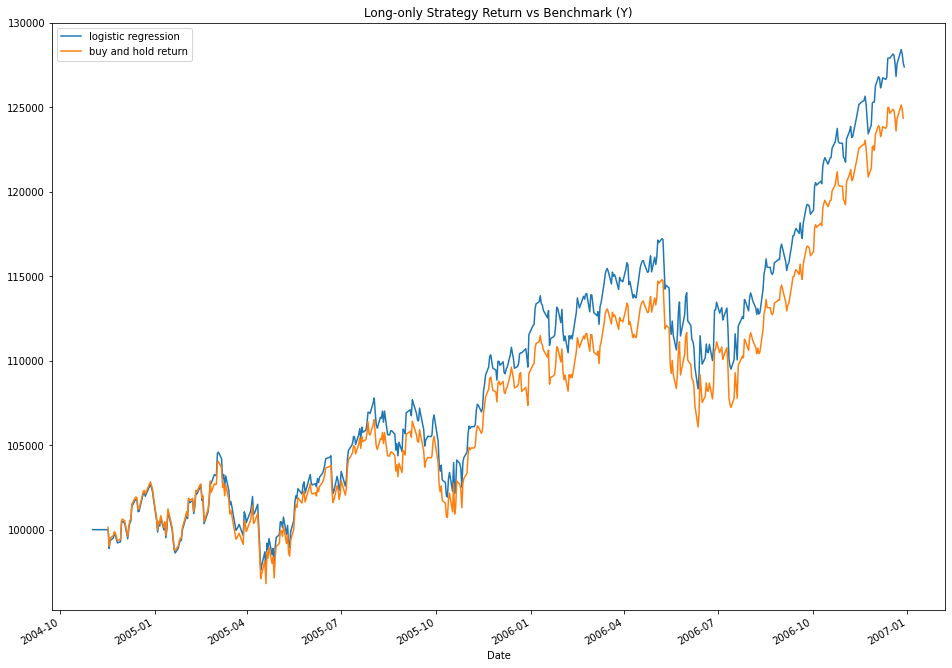

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.298e-02, tolerance: 4.655e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00055609 -0.000462   -0.00053646 -0.00034977 -0.00040949 -0.00054473
 -0.00028785 -0.00219267 -0.00150037 -0.0004965 ]
intercept is 2.685 and coefficients are [-3.14996639 -3.72149408 -2.66646972 -3.13361219 -3.12340644 -3.12905318
 -3.11190061 -0.42723903 -0.21843063 -3.69110097]
Name of features used: ['x68' 'x92' 'x104' 'x111' 'x127' 'x128' 'x129' 'x166' 'x171' 'x207']
 
Accuracy : 0.39158163265306123
 
Precision : 0.46568627450980393
 
Recall : 0.6551724137931034


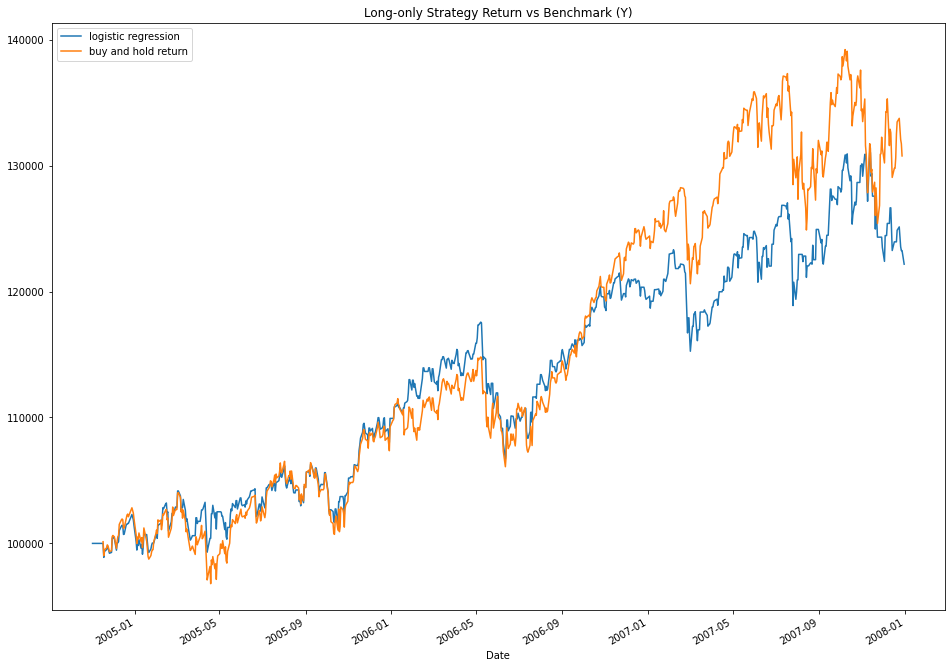

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.058e-01, tolerance: 2.176e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00452401 -0.00340659  0.00031214 -0.00437604  0.00025077 -0.00430759
 -0.00445443 -0.00438544 -0.00448366  0.00048269]
intercept is 1.718 and coefficients are [-3.76775109 -3.07357608 -1.28137964 -2.84986114 -1.15983941 -3.53422938
 -3.53701364 -3.52874673 -3.52650517 -1.45484872]
Name of features used: ['x40' 'x85' 'x86' 'x121' 'x122' 'x149' 'x187' 'x188' 'x189' 'x193']
 
Accuracy : 0.5467695274831244
 
Precision : 0.5457286432160804
 
Recall : 0.9679144385026738


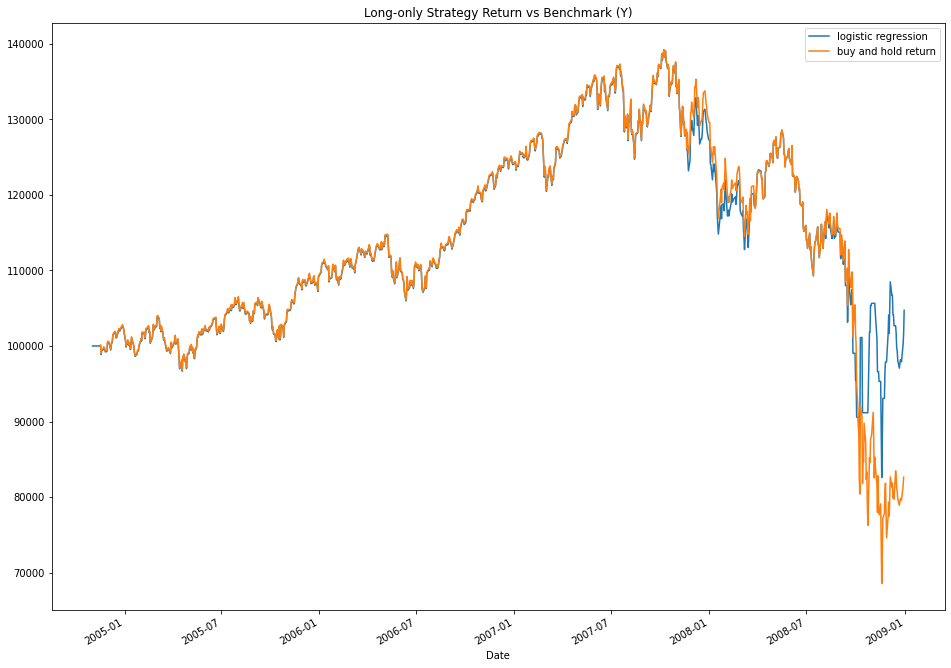

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e-01, tolerance: 2.878e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00368113 -0.00310009 -0.00355907 -0.00348332 -0.00362669 -0.0036133
 -0.00364937 -0.00284764 -0.00282566 -0.00280356]
intercept is 1.511 and coefficients are [-3.39609685 -2.56866269 -2.78842572 -3.23681619 -3.24036477 -3.23581666
 -3.21359964 -6.01467682 -6.01277963 -6.0138471 ]
Name of features used: ['x40' 'x85' 'x121' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205' 'x207']
 
Accuracy : 0.41194724592707527
 
Precision : 0.47338403041825095
 
Recall : 0.7094017094017094


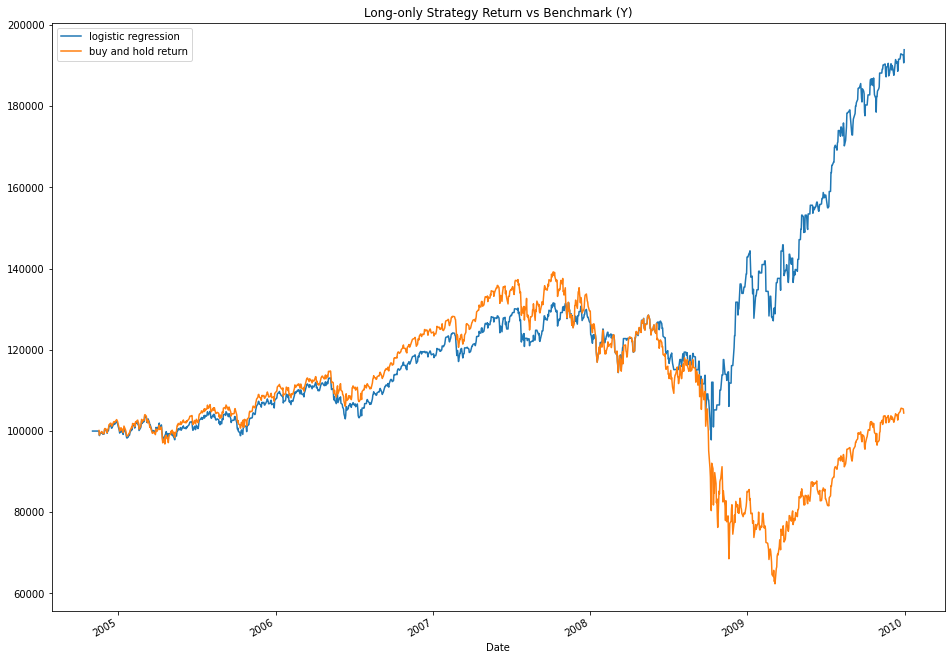

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e-01, tolerance: 3.197e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.001 and coefficients are [-0.00343157 -0.00289904 -0.00336039 -0.0032596  -0.00338603 -0.00337822
 -0.00340759 -0.0025647  -0.0025114  -0.00245873]
intercept is 1.772 and coefficients are [-3.80073118 -2.83468167 -3.0919847  -3.61792427 -3.62201268 -3.61661472
 -3.59086389 -6.3686046  -6.35165387 -6.33776563]
Name of features used: ['x40' 'x85' 'x121' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205' 'x207']
 
Accuracy : 0.4289422452952628
 
Precision : 0.4875
 
Recall : 0.7358490566037735


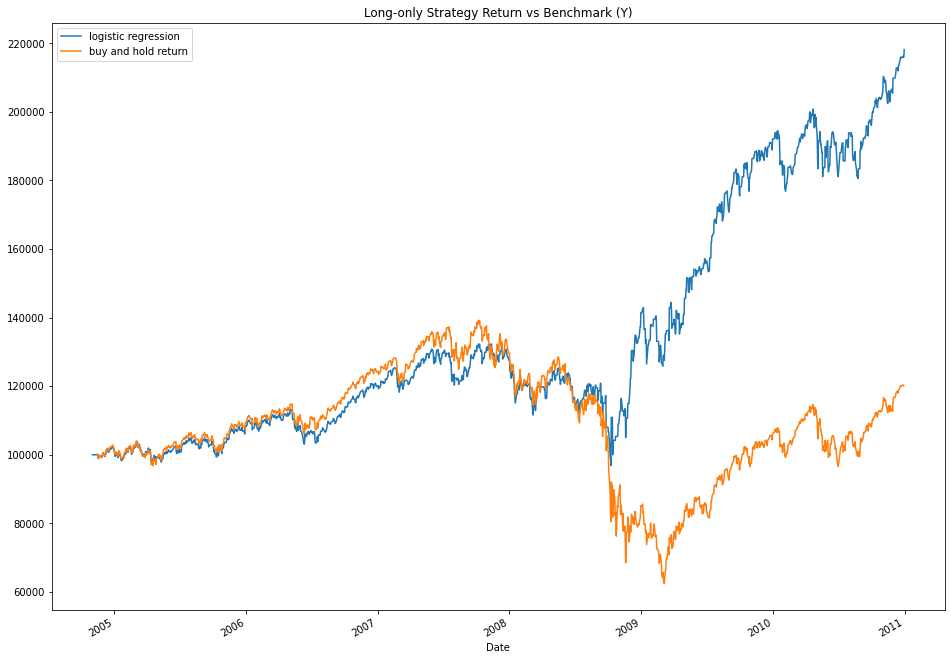

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e-01, tolerance: 3.730e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00305371 -0.00258312 -0.00277757 -0.00304463 -0.00289569 -0.00301987
 -0.00303736 -0.00304986 -0.00265759 -0.00253205]
intercept is 1.671 and coefficients are [-4.04394389 -7.52333084 -2.85317615 -3.28285069 -3.84740041 -3.84925582
 -3.85309359 -3.82620756 -6.80326144 -6.79157956]
Name of features used: ['x40' 'x46' 'x85' 'x121' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205']
 
Accuracy : 0.403792526491913
 
Precision : 0.46996466431095407
 
Recall : 0.6758130081300813


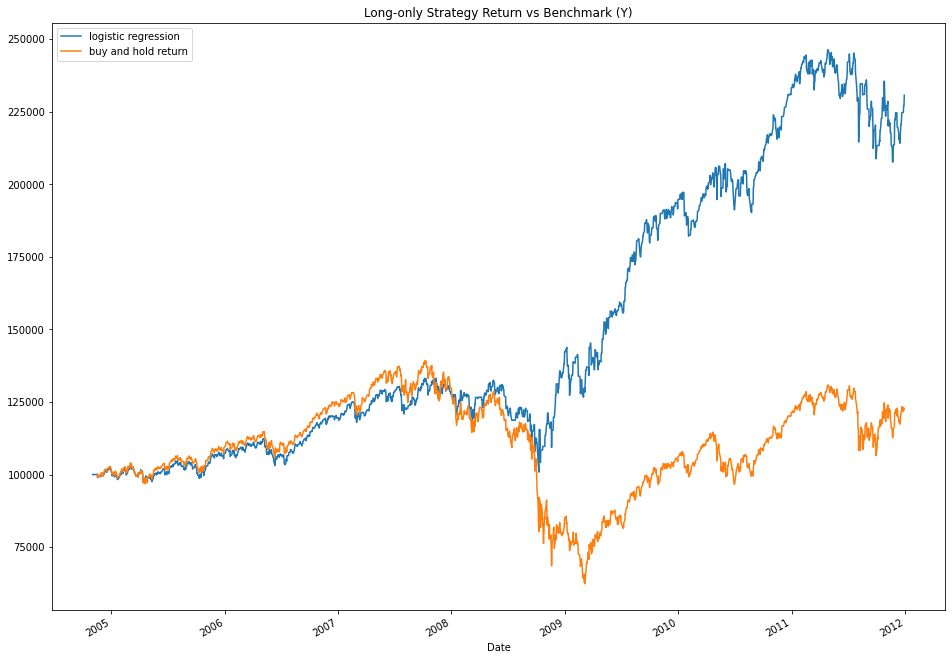

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 3.895e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00296427 -0.00265513 -0.00292697 -0.00203138 -0.00281462 -0.00292581
 -0.00294013 -0.00294774 -0.00277072 -0.00263892]
intercept is 1.945 and coefficients are [-4.24774525 -2.96417695 -3.42109239 -5.84496383 -4.03333068 -4.03713061
 -4.035724   -4.01184718 -8.07066423 -8.04548075]
Name of features used: ['x40' 'x85' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205']
 
Accuracy : 0.4331864904552129
 
Precision : 0.4892002335084647
 
Recall : 0.7475468331846565


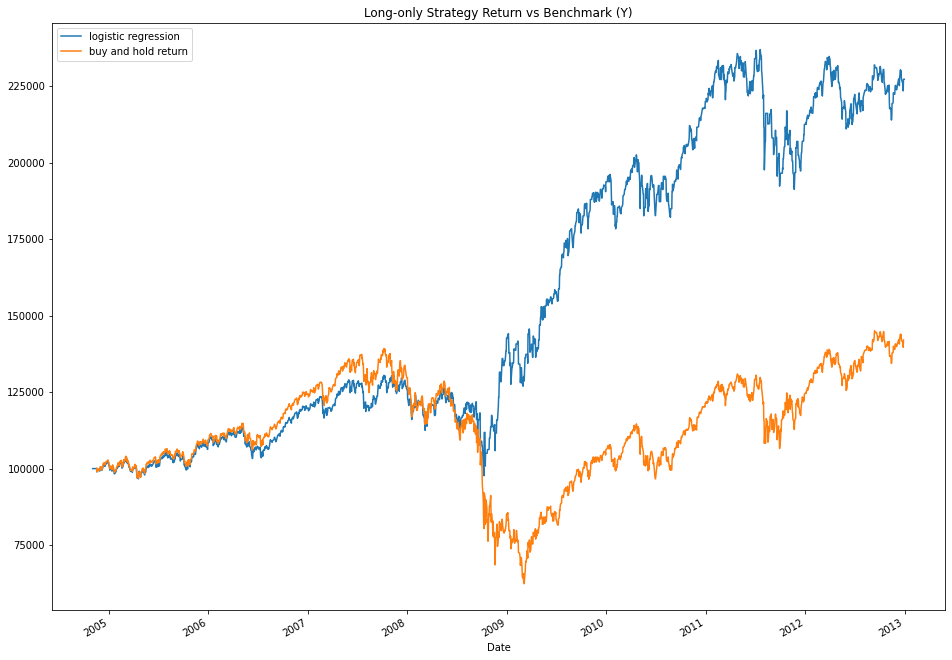

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-01, tolerance: 4.013e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.001 and coefficients are [-0.00287475 -0.00255459 -0.00282739 -0.00201114 -0.00273499 -0.00283453
 -0.00284781 -0.00285213 -0.00265115 -0.00254319]
intercept is 2.216 and coefficients are [-4.42545455 -3.0443064  -3.54763797 -6.00948246 -4.19750199 -4.20302564
 -4.19920503 -4.17344034 -8.27304636 -8.25333583]
Name of features used: ['x40' 'x85' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205']
 
Accuracy : 0.4522875816993464
 
Precision : 0.5025150905432596
 
Recall : 0.7884767166535123


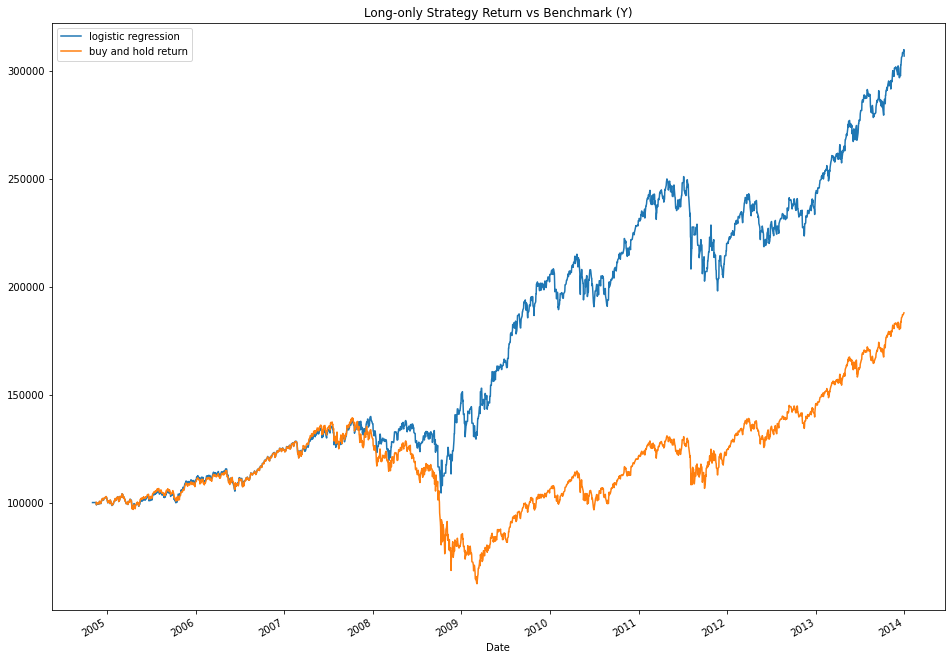

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.041e-01, tolerance: 4.139e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.001 and coefficients are [-0.00275795 -0.00244848 -0.00271458 -0.00194294 -0.00262805 -0.00271939
 -0.00273276 -0.00273523 -0.00244038 -0.00234166]
intercept is 2.405 and coefficients are [-4.63360306 -3.16281091 -3.69151057 -6.14024577 -4.38932216 -4.39634105
 -4.38839203 -4.36480218 -8.37368098 -8.36416722]
Name of features used: ['x40' 'x85' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205']
 
Accuracy : 0.4668237141735375
 
Precision : 0.5129464285714286
 
Recall : 0.8114406779661016


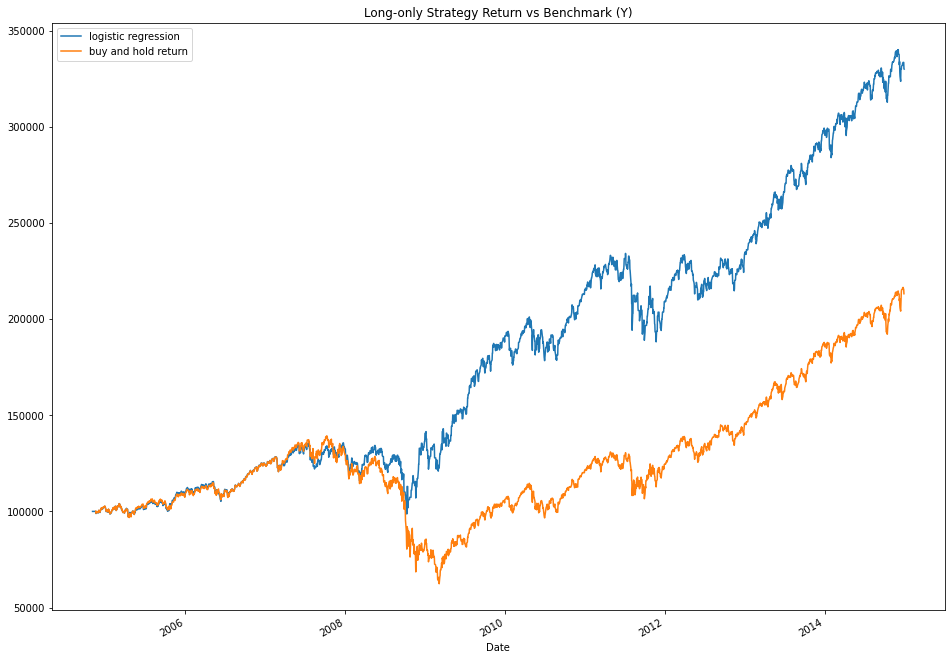

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e-01, tolerance: 4.379e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.0026662  -0.00234385 -0.00206908 -0.00259767 -0.00215771 -0.00253942
 -0.00262247 -0.00264068 -0.00263764 -0.0026396 ]
intercept is 2.327 and coefficients are [ -4.82020308  -3.16586175  -7.24259053  -3.80803686  -7.42633492
  -4.55586284  -4.56263977  -4.55519362  -4.52575389 -10.1934479 ]
Name of features used: ['x40' 'x85' 'x91' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189' 'x204']
 
Accuracy : 0.45837799214005004
 
Precision : 0.5042561815970815
 
Recall : 0.8093689004554326


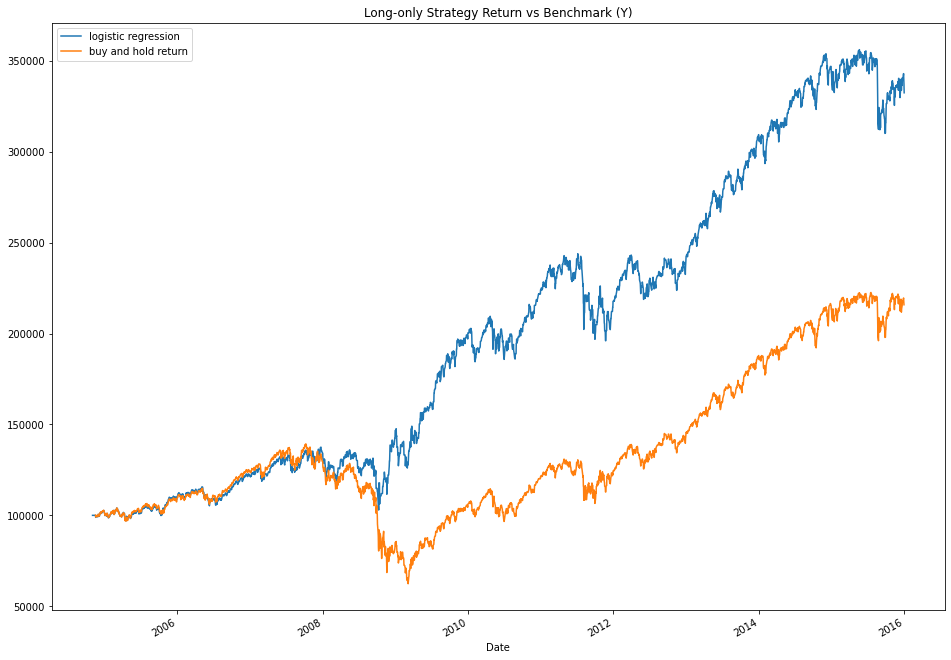

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.248e-01, tolerance: 4.548e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.001 and coefficients are [-0.00262653 -0.00198161 -0.00226409 -0.00248584 -0.00253283 -0.00271489
 -0.00250107 -0.00257668 -0.00259157 -0.00258782]
intercept is 2.462 and coefficients are [-5.13340638 -6.55883942 -3.29045982 -8.80289955 -4.00581154 -9.5528792
 -4.83901495 -4.84065475 -4.82758943 -4.80305461]
Name of features used: ['x40' 'x68' 'x85' 'x91' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189']
 
Accuracy : 0.4860701409373976
 
Precision : 0.5189692197566214
 
Recall : 0.8661887694145759


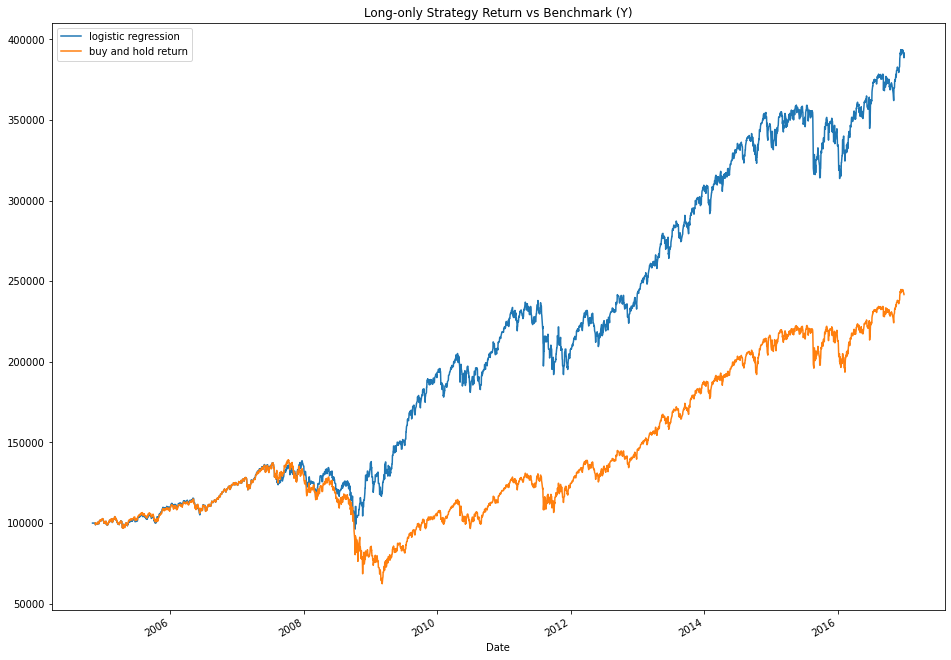

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e-01, tolerance: 4.593e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.001 and coefficients are [-0.00255216 -0.00219068 -0.00200909 -0.00245164 -0.00209522 -0.00243176
 -0.00250151 -0.002516   -0.00251119 -0.00256987]
intercept is 2.605 and coefficients are [ -5.11226978  -3.32356176  -7.14702262  -4.01374382  -7.81859803
  -4.82308953  -4.82987378  -4.81882835  -4.79353784 -10.57188628]
Name of features used: ['x40' 'x85' 'x91' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189' 'x204']
 
Accuracy : 0.4766807995154452
 
Precision : 0.5149178679182032
 
Recall : 0.8453494771601541


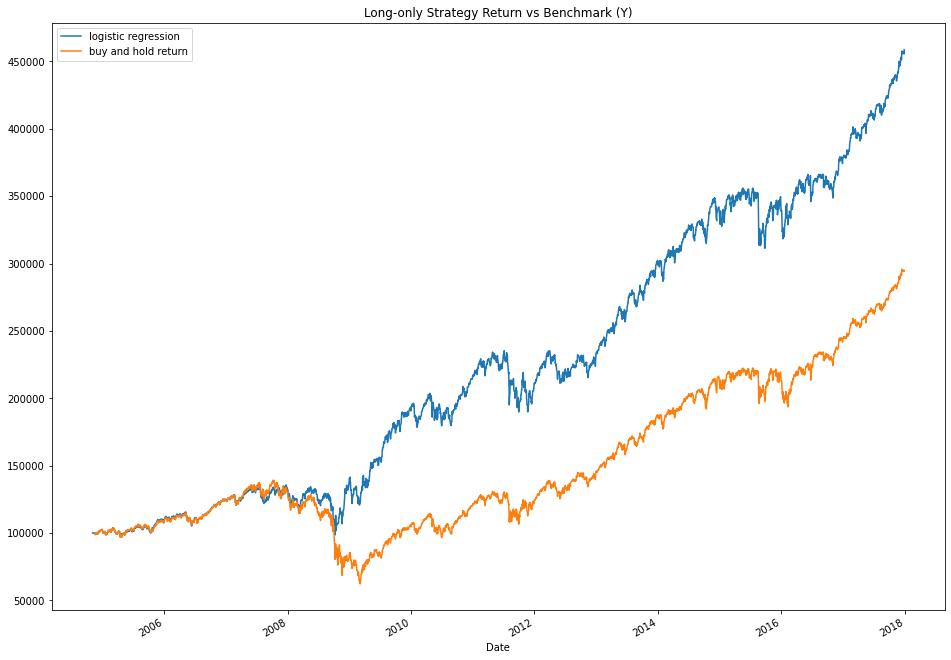

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.418e-01, tolerance: 4.883e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00239836 -0.00183831 -0.00207257 -0.00224386 -0.00232553 -0.00252428
 -0.00229111 -0.00235586 -0.0023752  -0.00236438]
intercept is 2.586 and coefficients are [-5.66711686 -6.87669406 -3.65197122 -9.15249177 -4.3525542  -9.92021122
 -5.31863425 -5.31716169 -5.29744098 -5.27300766]
Name of features used: ['x40' 'x68' 'x85' 'x91' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189']
 
Accuracy : 0.4914157050379961
 
Precision : 0.5218320610687023
 
Recall : 0.8764102564102564


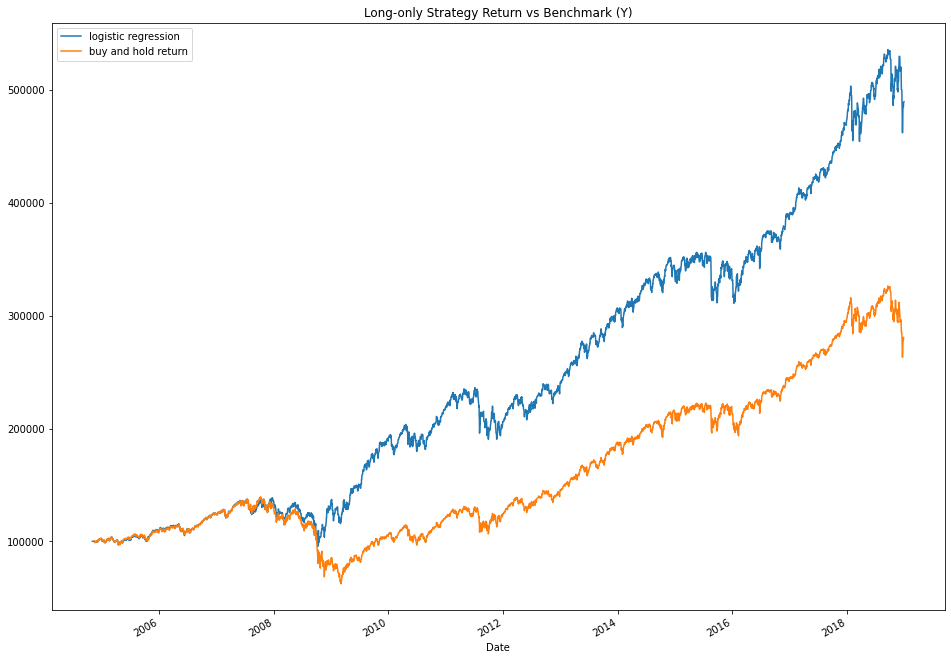

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.497e-01, tolerance: 5.041e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.001 and coefficients are [-0.00236027 -0.00181119 -0.00200731 -0.00221288 -0.00227467 -0.00248749
 -0.00225279 -0.00231749 -0.00233411 -0.00232166]
intercept is 2.833 and coefficients are [-5.80576258 -6.60593171 -3.71524539 -8.68572048 -4.44241819 -9.68710882
 -5.44019997 -5.44708902 -5.42511818 -5.39211466]
Name of features used: ['x40' 'x68' 'x85' 'x91' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189']
 
Accuracy : 0.5045992115637319
 
Precision : 0.530103612433492
 
Recall : 0.9014285714285715


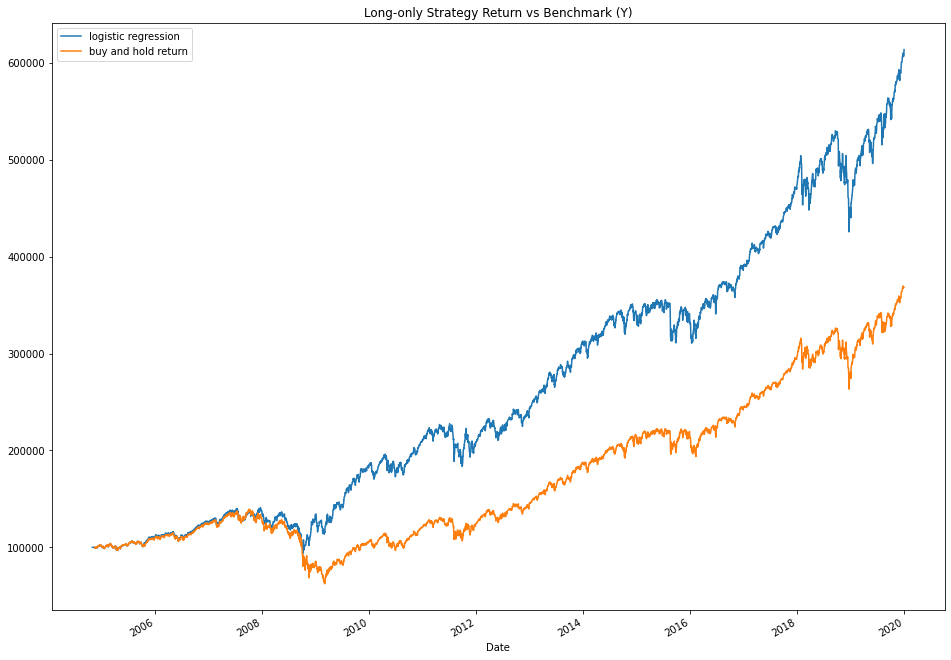

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e-01, tolerance: 6.175e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00237044 -0.00288569 -0.00231953 -0.00229347 -0.00219791 -0.00209823
 -0.001596   -0.00156853 -0.00146224 -0.00154125]
intercept is 1.936 and coefficients are [-6.98378557 -4.62304559 -6.3196549  -6.3169871  -6.28944071 -6.30075254
 -8.71706446 -8.71209347 -8.67292432 -8.71085935]
Name of features used: ['x22' 'x103' 'x110' 'x123' 'x124' 'x125' 'x138' 'x151' 'x152' 'x194']
 
Accuracy : 0.3918186298669295
 
Precision : 0.4647395171537484
 
Recall : 0.6513802315227071


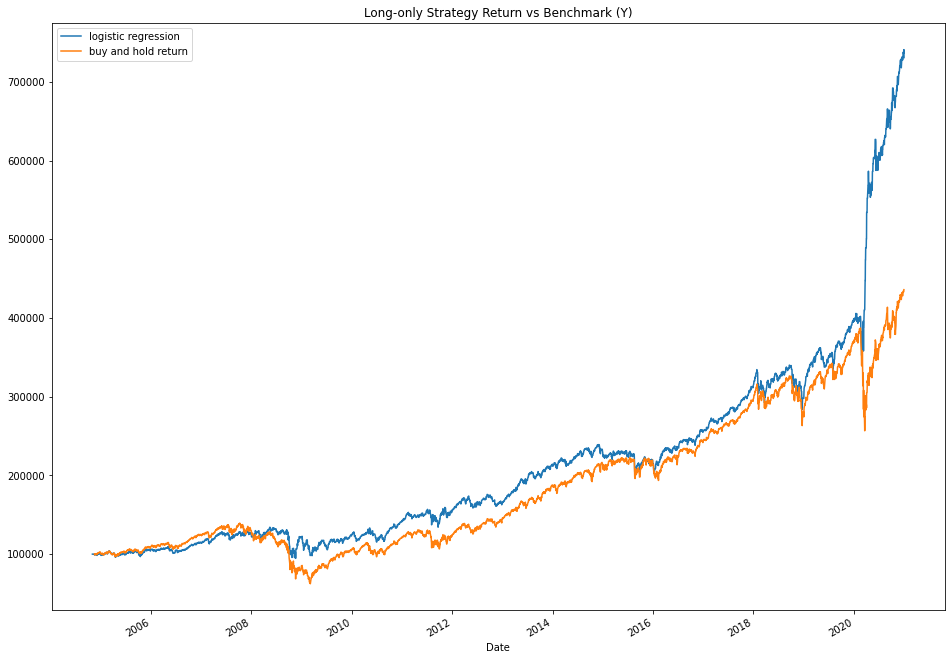

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.124e-01, tolerance: 6.342e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00231186 -0.00279568 -0.00226483 -0.00223609 -0.00215129 -0.00205298
 -0.00158616 -0.00155479 -0.00146107 -0.00152352]
intercept is 2.140 and coefficients are [-7.11408831 -4.76428862 -6.43640848 -6.43401464 -6.4053119  -6.41218692
 -8.77139963 -8.76653688 -8.72672416 -8.76568107]
Name of features used: ['x22' 'x103' 'x110' 'x123' 'x124' 'x125' 'x138' 'x151' 'x152' 'x194']
 
Accuracy : 0.4060324825986079
 
Precision : 0.4754529514903565
 
Recall : 0.6801839464882943


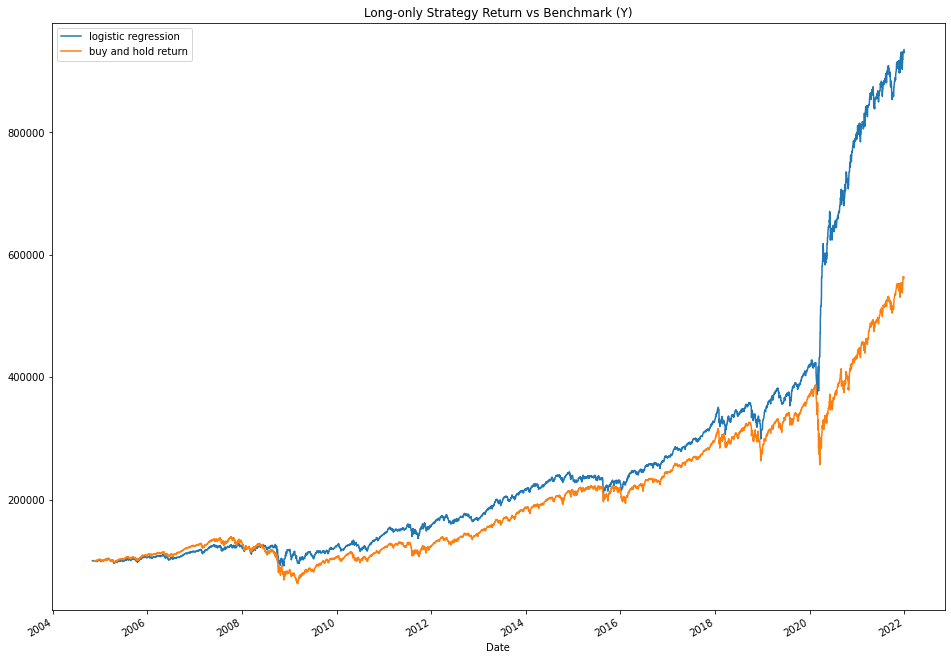

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.421e-01, tolerance: 6.930e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00213899 -0.00265777 -0.00212581 -0.00209519 -0.00202367 -0.00191939
 -0.00145262 -0.00141907 -0.00134105 -0.00138573]
intercept is 1.992 and coefficients are [-7.34797552 -4.90748392 -6.63104894 -6.63073072 -6.60227518 -6.61155792
 -9.04021456 -9.03852223 -8.99850936 -9.04073865]
Name of features used: ['x22' 'x103' 'x110' 'x123' 'x124' 'x125' 'x138' 'x151' 'x152' 'x194']
 
Accuracy : 0.38390703793027847
 
Precision : 0.4559954428937625
 
Recall : 0.6401439424230307


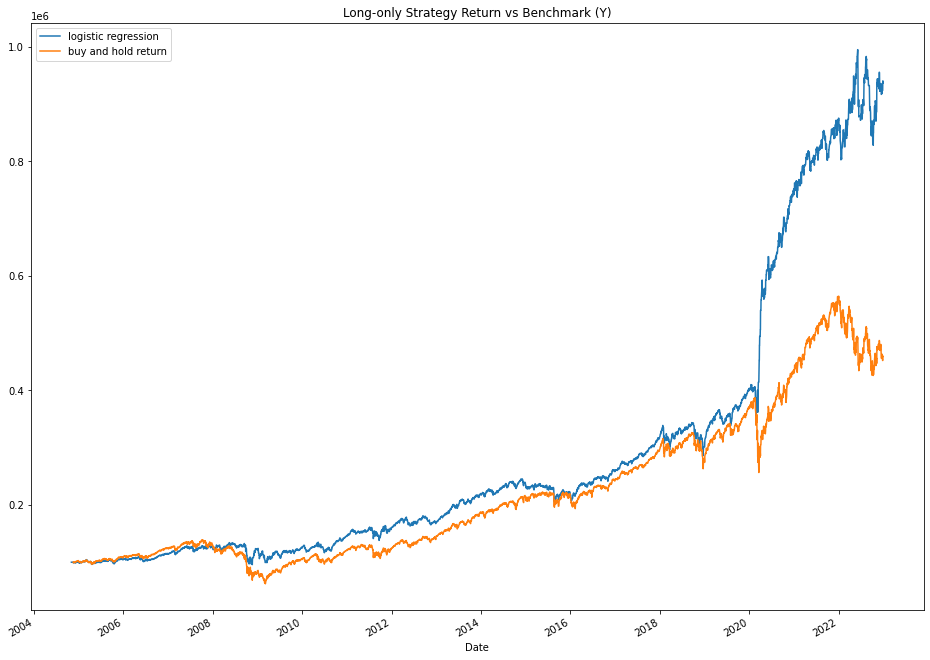

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.496e-01, tolerance: 7.079e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00209075 -0.00260163 -0.00208286 -0.00205219 -0.00198438 -0.0018823
 -0.00142338 -0.0013893  -0.00131554 -0.00135551]
intercept is 2.071 and coefficients are [-7.47317463 -5.00062957 -6.74242403 -6.74063719 -6.71205842 -6.72000605
 -9.16954755 -9.16598621 -9.12588784 -9.16626649]
Name of features used: ['x22' 'x103' 'x110' 'x123' 'x124' 'x125' 'x138' 'x151' 'x152' 'x194']
 
Accuracy : 0.3833088697840218
 
Precision : 0.4550638066793375
 
Recall : 0.6421455938697318


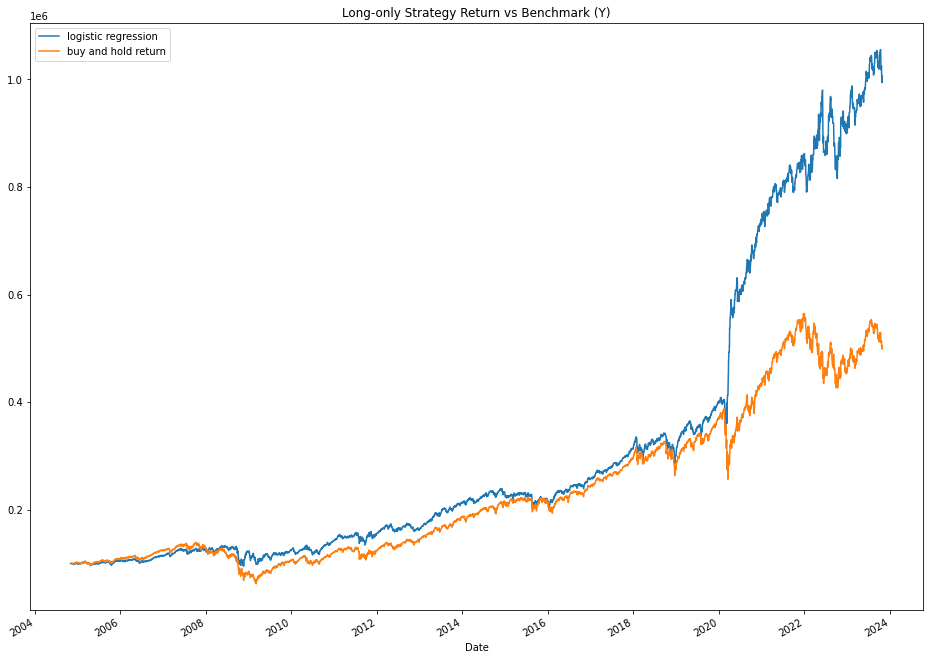

In [88]:
Y_traintest2 = Y_traintest.shift(-1).loc[index_] #1 day lookahead

params, X_traintest4= fit_and_predict(df_dict,Y_traintest2,penalty_)

In [89]:
X_traintest4["signal"].value_counts()

signal
1.0    3683
0.0    1098
Name: count, dtype: int64

In [90]:
(X_traintest4["strategy_return"].cumsum().apply(np.exp))

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25     9.983976
2023-10-26     9.938721
2023-10-27    10.057546
2023-10-30    10.057546
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

[Text(0.5, 0, 'predicted values'),
 Text(0, 0.5, 'target values'),
 Text(0.5, 1.0, 'Predicted vs Actual Responses')]

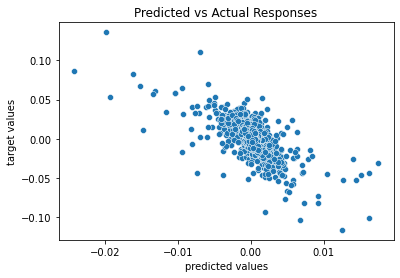

In [91]:
#can turn into a plot function

#linear correlation is expected of a plot between in-sample test and y_pred 
                    #params_dict[]
ax = sns.scatterplot(x=EN_pred_train2, y= Y_traintest.iloc[:-2])
ax.set(xlabel='predicted values', ylabel='target values',title="Predicted vs Actual Responses")

In [92]:
#this can be removed later. this is a long-short strategy 

penalty_ = 0.0

def fit_and_predict_w_short(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        elastic_net = ElasticNet(alpha=0.01, l1_ratio=penalty_)

        elastic_net.fit(df_dict[year_], Y_traintest_series_fraction)
        print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

        EN_pred_train2 = elastic_net.predict(df_dict[year_])


        #continuous predictions are turned into binary signal or 1 and 0 
        Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)


        logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
        logreg_sk2.fit(df_dict[year_], Y_pred_binary2)
        print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))
        

        Y_pred_logistic2 = logreg_sk2.predict(df_dict[year_])

        Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = df_dict[year_].index)

        params_dict[f"EN_pred_{year_}"] = EN_pred_train2
        params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
        params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

        params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
        params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
        params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
        print("Name of features used: {}".format(elastic_net.feature_names_in_))
        print(" ")
        print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
        print(" ")
        print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        print(" ")
        print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        
        #long and short
        
        X_traintest3 = df_dict[year_].copy()
        X_traintest3["signal"] = Y_pred_logistic2_df
        X_traintest3["signal"].iloc[:13] = 0
        
        signal = X_traintest3["signal"].copy()
        short_signal = (signal == 0) * -1 
        signals = short_signal + signal
        signals.iloc[:12] = 0
        
        X_traintest3["signal"] = signals
        

        X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Long&Short Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.257e-04, tolerance: 6.961e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

intercept is -0.002 and coefficients are [ 2.38569671e-03  7.73573829e-05  3.63084957e-04 -8.39533593e-06
  2.60018905e-04  6.33238938e-04  2.52650748e-04  5.00321537e-04
  1.11440365e-04  3.25758888e-04]
intercept is 1.911 and coefficients are [0.0541544  0.73370628 0.71626789 0.73478855 0.73590558 0.69971382
 0.71761916 0.71864605 0.73721102 0.73862115]
Name of features used: ['x78' 'x102' 'x109' 'x118' 'x119' 'x137' 'x146' 'x147' 'x180' 'x182']
 
Accuracy : 0.9
 
Precision : 0.8636363636363636
 
Recall : 1.0


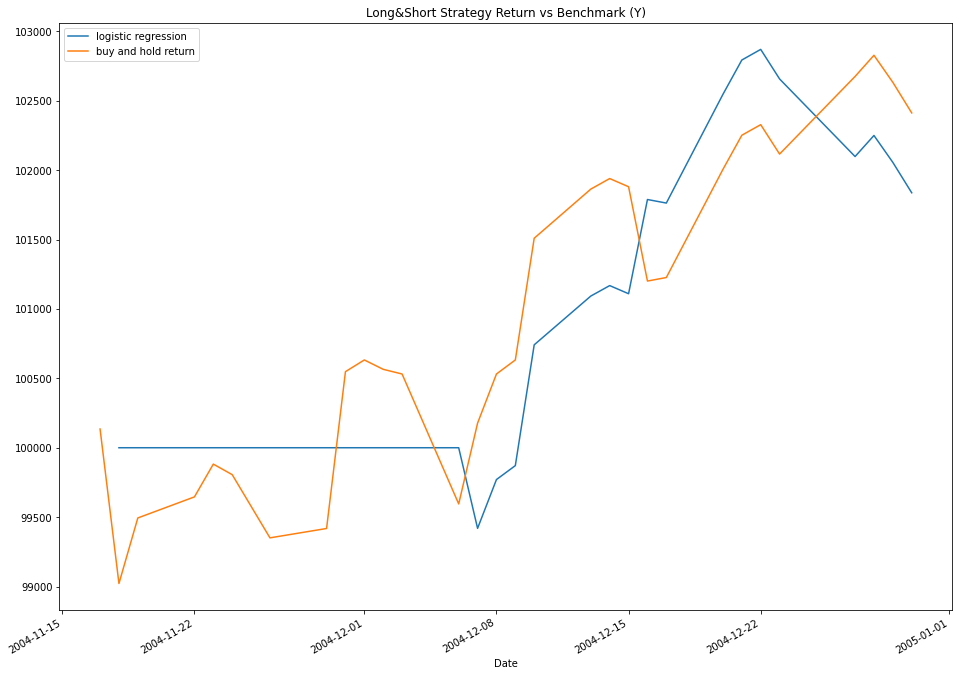

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.662e-03, tolerance: 1.158e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

intercept is -0.008 and coefficients are [ 0.00103666  0.00105304  0.00160122  0.00163195  0.00102716  0.00130032
  0.0010544   0.00131711 -0.00262643 -0.00185881]
intercept is -11.769 and coefficients are [ 1.67564862  1.58061419  2.6564308   2.57694669  1.88199291  1.81366578
  1.79548784  1.7220621  -3.23911112 -1.2626738 ]
Name of features used: ['x20' 'x26' 'x101' 'x107' 'x112' 'x114' 'x132' 'x135' 'x164' 'x165']
 
Accuracy : 0.4645390070921986
 
Precision : 0.5118483412322274
 
Recall : 0.6923076923076923


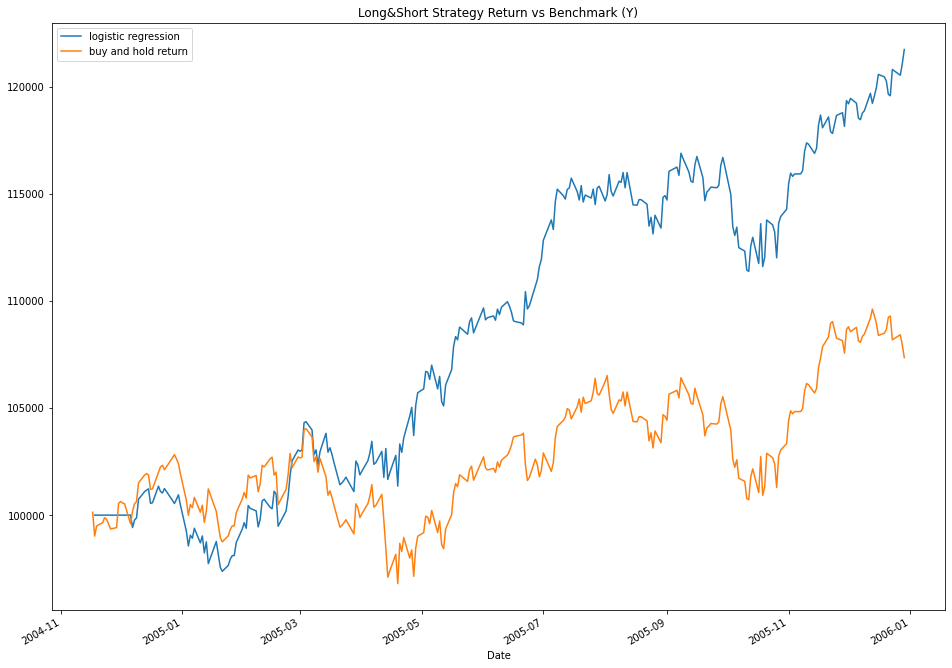

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.046e-02, tolerance: 2.124e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

intercept is -0.005 and coefficients are [ 0.00084909  0.0013824   0.00124358  0.00104721  0.0007633   0.00113832
  0.00083346  0.0009374  -0.0032026  -0.00218254]
intercept is -10.687 and coefficients are [ 2.09194256  3.2817809   2.94014713  2.69150325  1.92644741  2.29515551
  1.90088754  1.99226067 -2.85592476 -1.978359  ]
Name of features used: ['x24' 'x100' 'x105' 'x107' 'x112' 'x130' 'x131' 'x132' 'x164' 'x166']
 
Accuracy : 0.5459662288930581
 
Precision : 0.5521821631878557
 
Recall : 0.9797979797979798


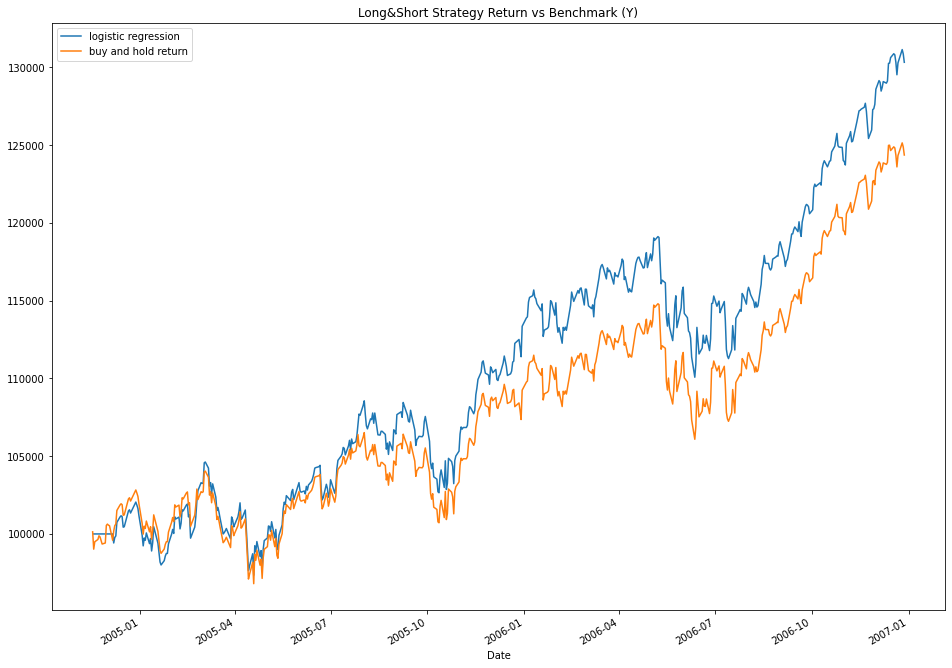

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.298e-02, tolerance: 4.655e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.00055609 -0.000462   -0.00053646 -0.00034977 -0.00040949 -0.00054473
 -0.00028785 -0.00219267 -0.00150037 -0.0004965 ]
intercept is 2.685 and coefficients are [-3.14968027 -3.72038506 -2.66717983 -3.13397416 -3.12395881 -3.12929703
 -3.11251381 -0.4247203  -0.21896043 -3.69061028]
Name of features used: ['x68' 'x92' 'x104' 'x111' 'x127' 'x128' 'x129' 'x166' 'x171' 'x207']
 
Accuracy : 0.39158163265306123
 
Precision : 0.46568627450980393
 
Recall : 0.6551724137931034


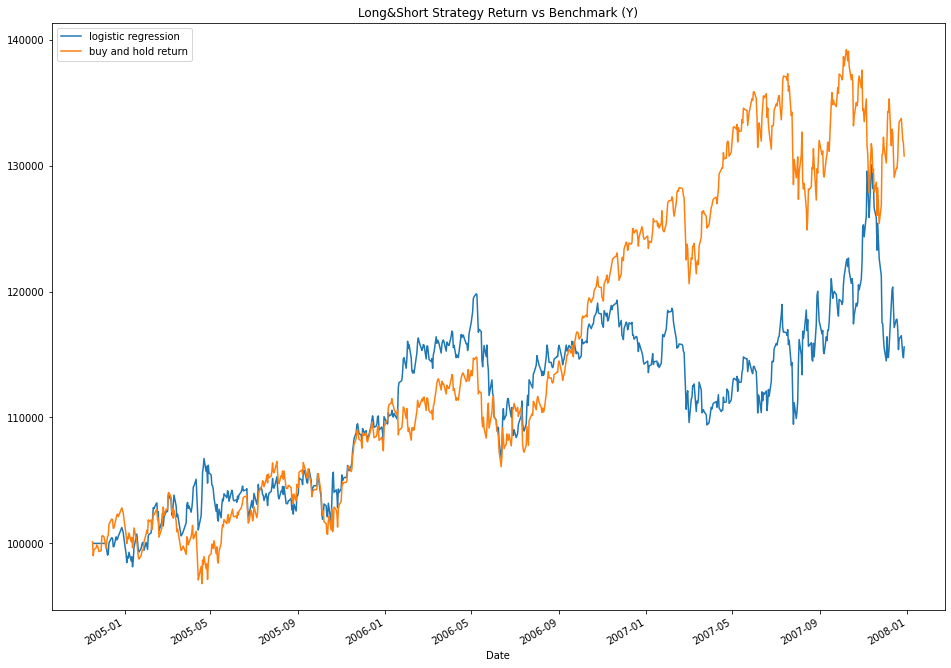

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.058e-01, tolerance: 2.176e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.00452401 -0.00340659  0.00031214 -0.00437604  0.00025077 -0.00430759
 -0.00445443 -0.00438544 -0.00448366  0.00048269]
intercept is 1.718 and coefficients are [-3.76779927 -3.07359056 -1.2814182  -2.84926218 -1.15955865 -3.53405884
 -3.53694232 -3.52876819 -3.52657595 -1.45521354]
Name of features used: ['x40' 'x85' 'x86' 'x121' 'x122' 'x149' 'x187' 'x188' 'x189' 'x193']
 
Accuracy : 0.5467695274831244
 
Precision : 0.5457286432160804
 
Recall : 0.9679144385026738


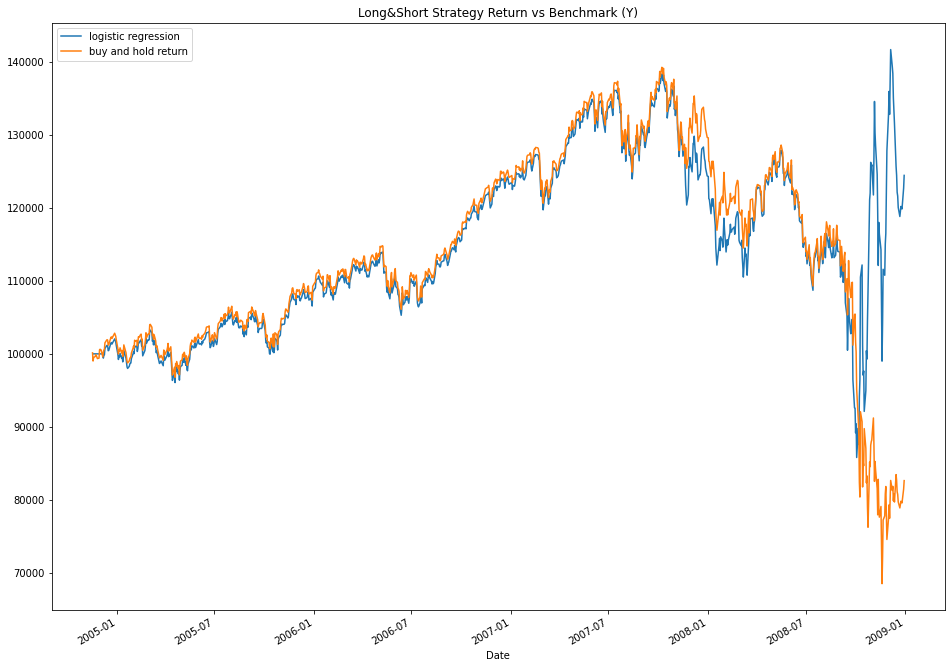

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e-01, tolerance: 2.878e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.00368113 -0.00310009 -0.00355907 -0.00348332 -0.00362669 -0.0036133
 -0.00364937 -0.00284764 -0.00282566 -0.00280356]
intercept is 1.511 and coefficients are [-3.39673546 -2.56998197 -2.78881675 -3.23749495 -3.24088478 -3.23657186
 -3.21413879 -6.01460321 -6.01286843 -6.01409904]
Name of features used: ['x40' 'x85' 'x121' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205' 'x207']
 
Accuracy : 0.41194724592707527
 
Precision : 0.47338403041825095
 
Recall : 0.7094017094017094


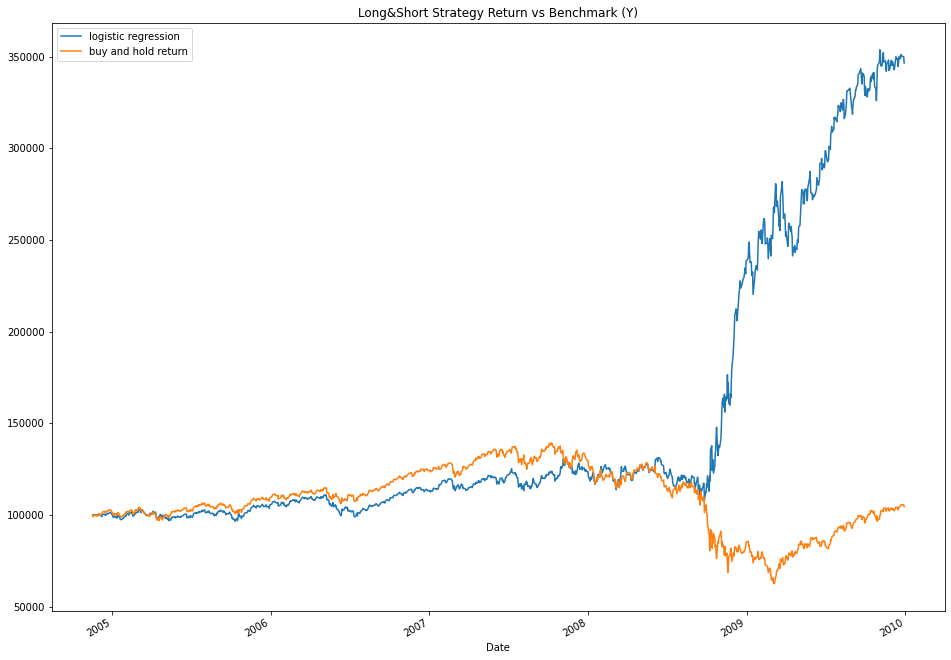

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e-01, tolerance: 3.197e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.001 and coefficients are [-0.00343157 -0.00289904 -0.00336039 -0.0032596  -0.00338603 -0.00337822
 -0.00340759 -0.0025647  -0.0025114  -0.00245873]
intercept is 1.772 and coefficients are [-3.80038462 -2.83617053 -3.09084155 -3.61740823 -3.62187714 -3.61645492
 -3.59017533 -6.36879819 -6.35152044 -6.33732483]
Name of features used: ['x40' 'x85' 'x121' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205' 'x207']
 
Accuracy : 0.4289422452952628
 
Precision : 0.4875
 
Recall : 0.7358490566037735


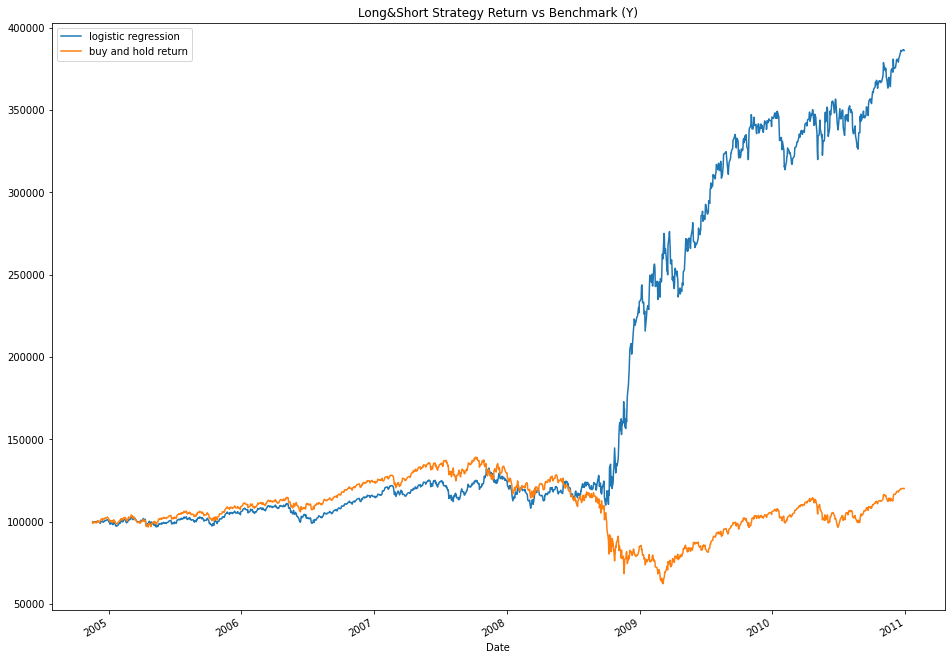

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e-01, tolerance: 3.730e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.00305371 -0.00258312 -0.00277757 -0.00304463 -0.00289569 -0.00301987
 -0.00303736 -0.00304986 -0.00265759 -0.00253205]
intercept is 1.671 and coefficients are [-4.04398692 -7.52375526 -2.85444623 -3.28332304 -3.84759487 -3.84945665
 -3.85297113 -3.82639457 -6.8034476  -6.79137704]
Name of features used: ['x40' 'x46' 'x85' 'x121' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205']
 
Accuracy : 0.403792526491913
 
Precision : 0.46996466431095407
 
Recall : 0.6758130081300813


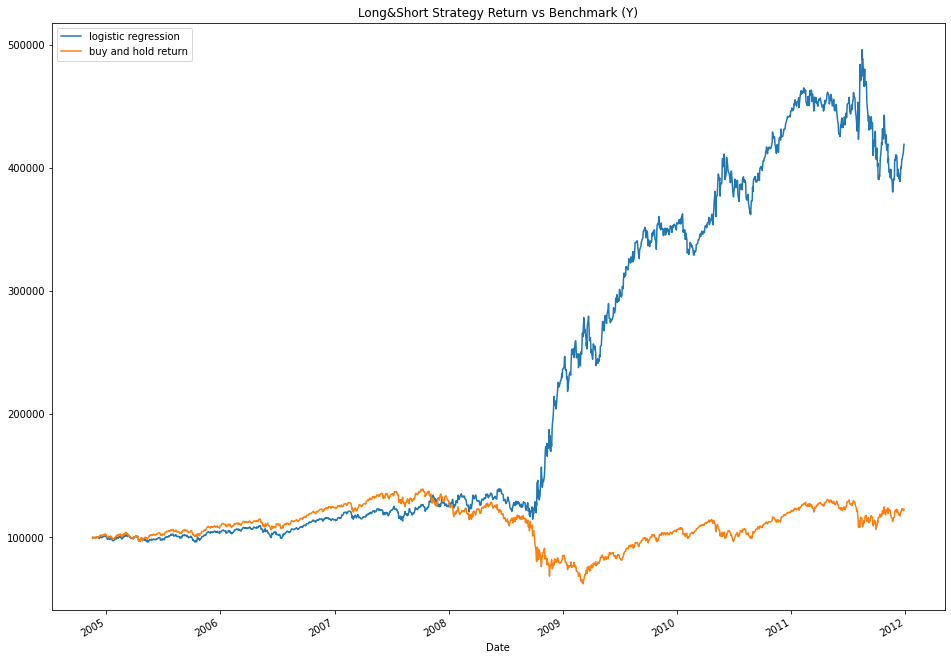

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 3.895e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.00296427 -0.00265513 -0.00292697 -0.00203138 -0.00281462 -0.00292581
 -0.00294013 -0.00294774 -0.00277072 -0.00263892]
intercept is 1.945 and coefficients are [-4.2474036  -2.96408796 -3.42141181 -5.84402661 -4.03300104 -4.03706075
 -4.03576345 -4.01149476 -8.07069508 -8.04556215]
Name of features used: ['x40' 'x85' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205']
 
Accuracy : 0.4331864904552129
 
Precision : 0.4892002335084647
 
Recall : 0.7475468331846565


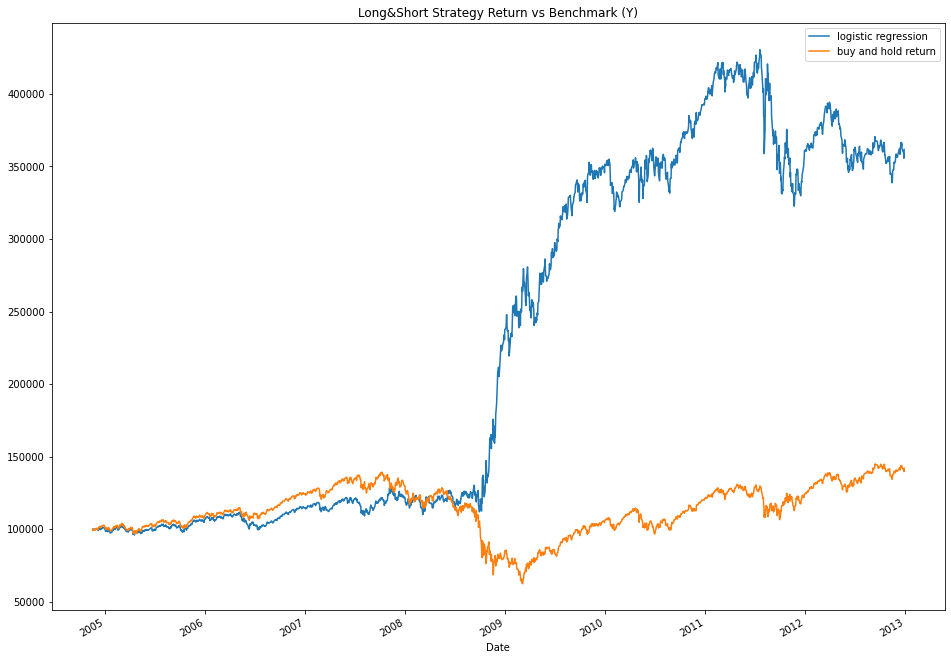

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-01, tolerance: 4.013e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.001 and coefficients are [-0.00287475 -0.00255459 -0.00282739 -0.00201114 -0.00273499 -0.00283453
 -0.00284781 -0.00285213 -0.00265115 -0.00254319]
intercept is 2.216 and coefficients are [-4.42551844 -3.04356394 -3.5481815  -6.00852097 -4.19749952 -4.20322348
 -4.19972266 -4.17380362 -8.27415823 -8.25328814]
Name of features used: ['x40' 'x85' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205']
 
Accuracy : 0.4522875816993464
 
Precision : 0.5025150905432596
 
Recall : 0.7884767166535123


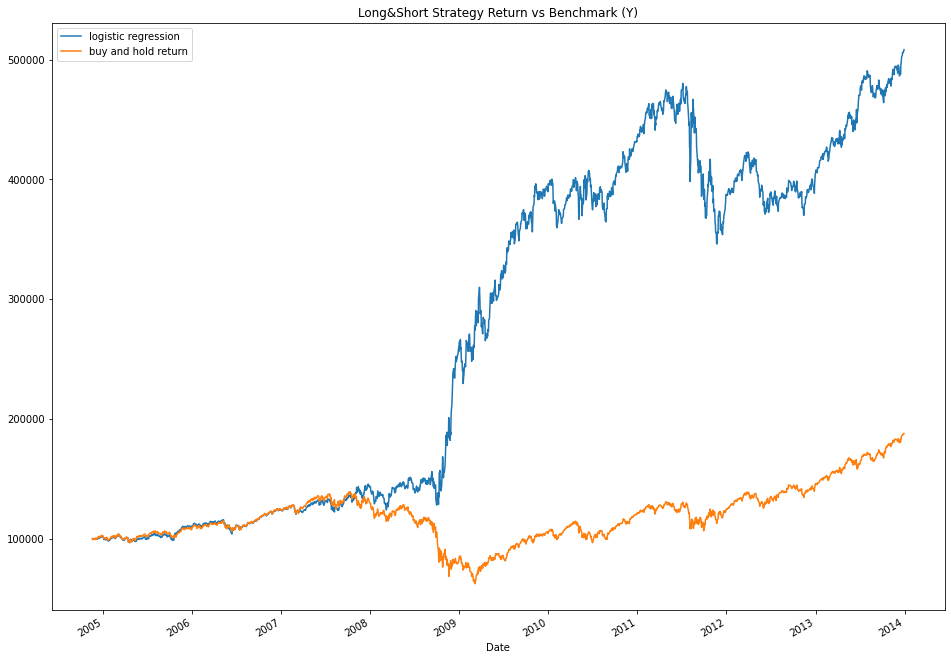

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.041e-01, tolerance: 4.139e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.001 and coefficients are [-0.00275795 -0.00244848 -0.00271458 -0.00194294 -0.00262805 -0.00271939
 -0.00273276 -0.00273523 -0.00244038 -0.00234166]
intercept is 2.405 and coefficients are [-4.63383873 -3.16288916 -3.69105024 -6.14128627 -4.38931985 -4.39652529
 -4.3884601  -4.36472931 -8.37374246 -8.36356281]
Name of features used: ['x40' 'x85' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189' 'x204' 'x205']
 
Accuracy : 0.4668237141735375
 
Precision : 0.5129464285714286
 
Recall : 0.8114406779661016


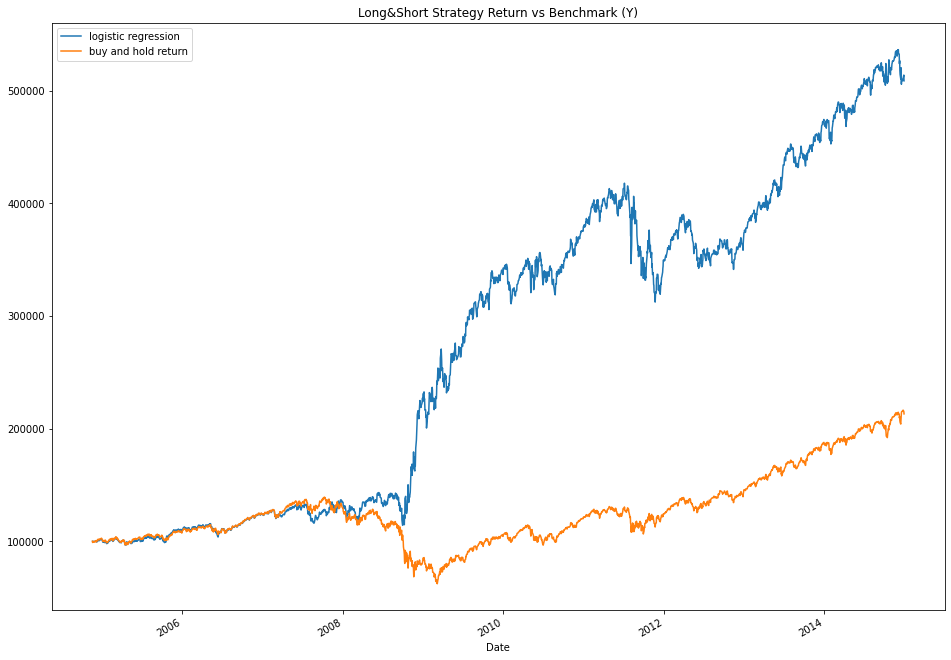

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e-01, tolerance: 4.379e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.0026662  -0.00234385 -0.00206908 -0.00259767 -0.00215771 -0.00253942
 -0.00262247 -0.00264068 -0.00263764 -0.0026396 ]
intercept is 2.327 and coefficients are [ -4.8196577   -3.16254077  -7.24490303  -3.80579503  -7.42736649
  -4.55518607  -4.56180934  -4.55410945  -4.52501958 -10.18952117]
Name of features used: ['x40' 'x85' 'x91' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189' 'x204']
 
Accuracy : 0.45837799214005004
 
Precision : 0.5042561815970815
 
Recall : 0.8093689004554326


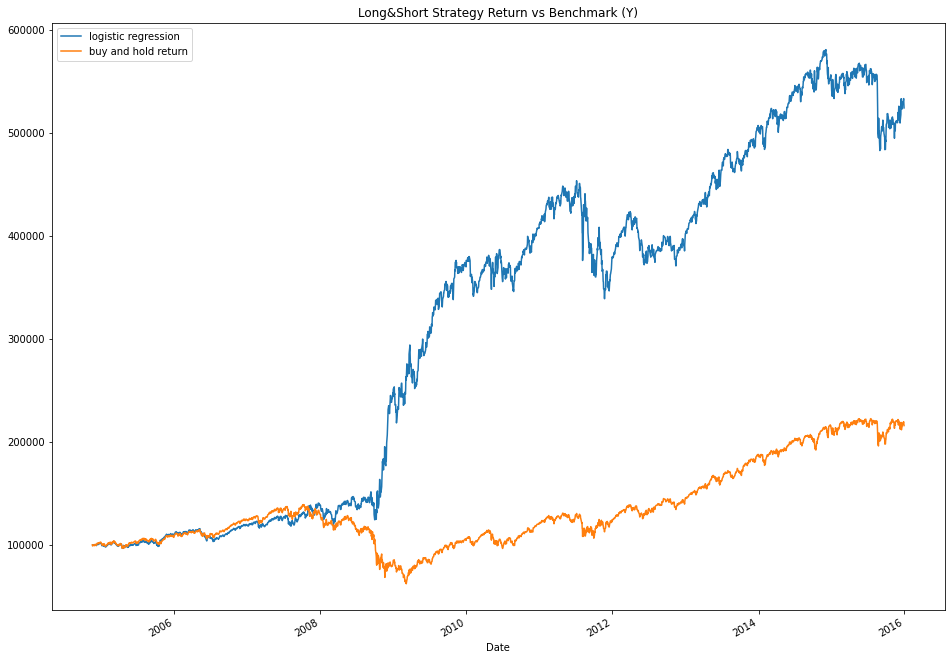

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.248e-01, tolerance: 4.548e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.001 and coefficients are [-0.00262653 -0.00198161 -0.00226409 -0.00248584 -0.00253283 -0.00271489
 -0.00250107 -0.00257668 -0.00259157 -0.00258782]
intercept is 2.462 and coefficients are [-5.13409811 -6.55910008 -3.28988571 -8.80326853 -4.00637567 -9.55274298
 -4.83952983 -4.84130764 -4.82821036 -4.80371702]
Name of features used: ['x40' 'x68' 'x85' 'x91' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189']
 
Accuracy : 0.4860701409373976
 
Precision : 0.5189692197566214
 
Recall : 0.8661887694145759


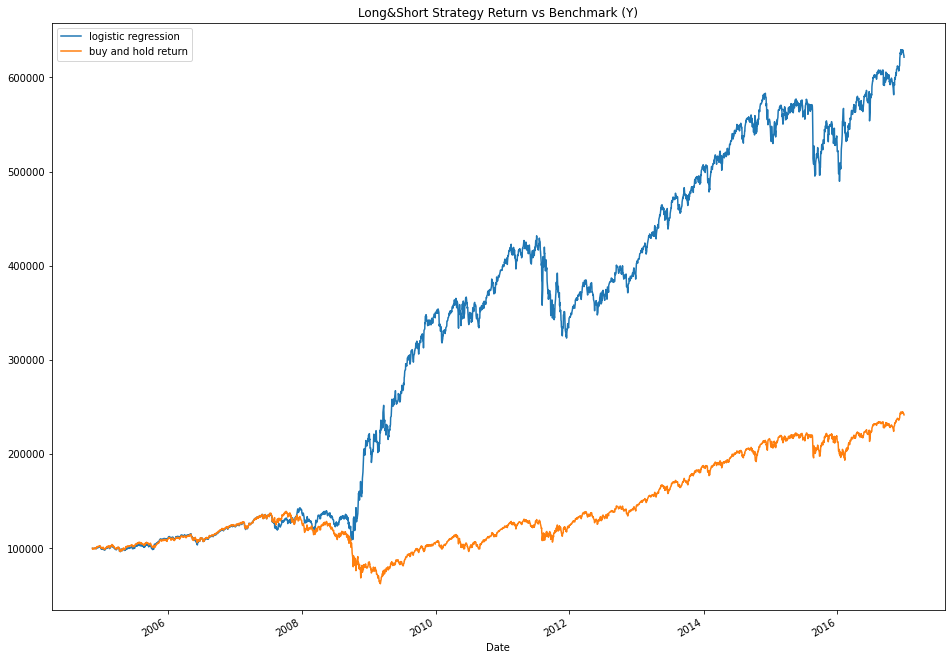

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e-01, tolerance: 4.593e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.001 and coefficients are [-0.00255216 -0.00219068 -0.00200909 -0.00245164 -0.00209522 -0.00243176
 -0.00250151 -0.002516   -0.00251119 -0.00256987]
intercept is 2.605 and coefficients are [ -5.11266888  -3.32422757  -7.14474936  -4.01298627  -7.82061783
  -4.82335069  -4.83001904  -4.81935518  -4.79385969 -10.57198575]
Name of features used: ['x40' 'x85' 'x91' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189' 'x204']
 
Accuracy : 0.4766807995154452
 
Precision : 0.5149178679182032
 
Recall : 0.8453494771601541


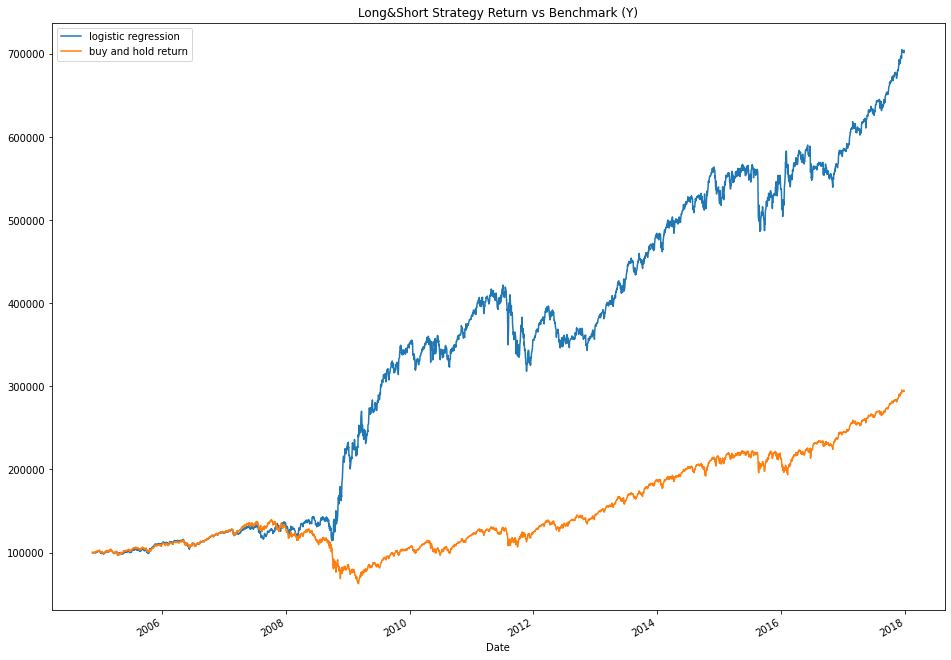

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.418e-01, tolerance: 4.883e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.00239836 -0.00183831 -0.00207257 -0.00224386 -0.00232553 -0.00252428
 -0.00229111 -0.00235586 -0.0023752  -0.00236438]
intercept is 2.586 and coefficients are [-5.6673224  -6.87612602 -3.6525374  -9.15357013 -4.35170639 -9.91985513
 -5.31861023 -5.31718088 -5.29778243 -5.27320853]
Name of features used: ['x40' 'x68' 'x85' 'x91' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189']
 
Accuracy : 0.4914157050379961
 
Precision : 0.5218320610687023
 
Recall : 0.8764102564102564


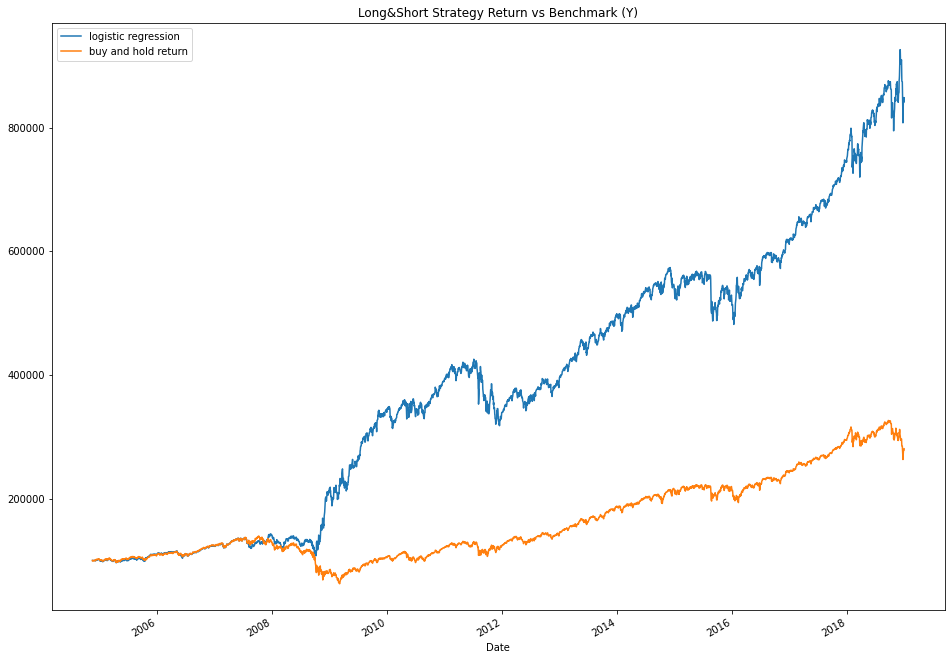

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.497e-01, tolerance: 5.041e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.001 and coefficients are [-0.00236027 -0.00181119 -0.00200731 -0.00221288 -0.00227467 -0.00248749
 -0.00225279 -0.00231749 -0.00233411 -0.00232166]
intercept is 2.833 and coefficients are [-5.80490362 -6.60676364 -3.71551918 -8.69092085 -4.44235253 -9.6815093
 -5.43953009 -5.44643868 -5.42447401 -5.39140892]
Name of features used: ['x40' 'x68' 'x85' 'x91' 'x121' 'x127' 'x149' 'x187' 'x188' 'x189']
 
Accuracy : 0.5045992115637319
 
Precision : 0.530103612433492
 
Recall : 0.9014285714285715


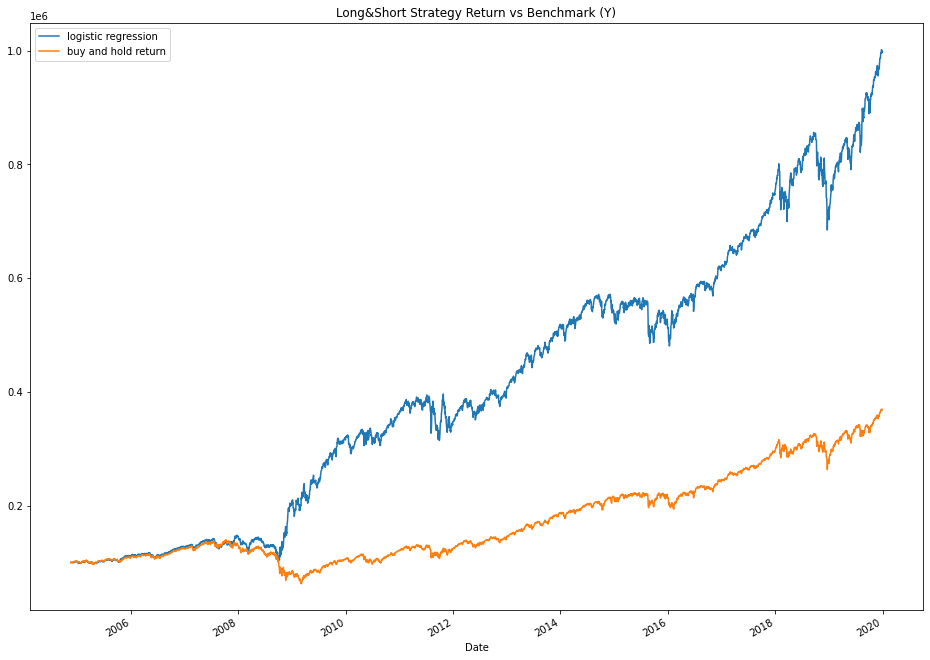

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e-01, tolerance: 6.175e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.00237044 -0.00288569 -0.00231953 -0.00229347 -0.00219791 -0.00209823
 -0.001596   -0.00156853 -0.00146224 -0.00154125]
intercept is 1.936 and coefficients are [-6.98378742 -4.62281588 -6.31963136 -6.31689926 -6.28921433 -6.30066635
 -8.71739238 -8.71234754 -8.672996   -8.71102947]
Name of features used: ['x22' 'x103' 'x110' 'x123' 'x124' 'x125' 'x138' 'x151' 'x152' 'x194']
 
Accuracy : 0.3918186298669295
 
Precision : 0.4647395171537484
 
Recall : 0.6513802315227071


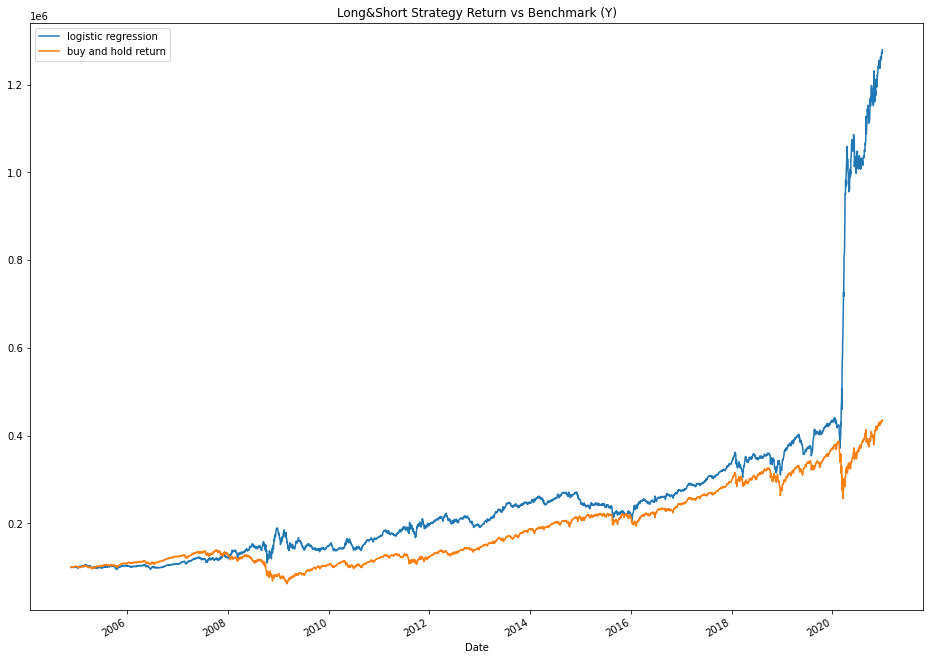

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.124e-01, tolerance: 6.342e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.00231186 -0.00279568 -0.00226483 -0.00223609 -0.00215129 -0.00205298
 -0.00158616 -0.00155479 -0.00146107 -0.00152352]
intercept is 2.140 and coefficients are [-7.1145111  -4.76446012 -6.43658727 -6.43387018 -6.40527443 -6.41230663
 -8.77152924 -8.76622666 -8.7265926  -8.76494849]
Name of features used: ['x22' 'x103' 'x110' 'x123' 'x124' 'x125' 'x138' 'x151' 'x152' 'x194']
 
Accuracy : 0.4060324825986079
 
Precision : 0.4754529514903565
 
Recall : 0.6801839464882943


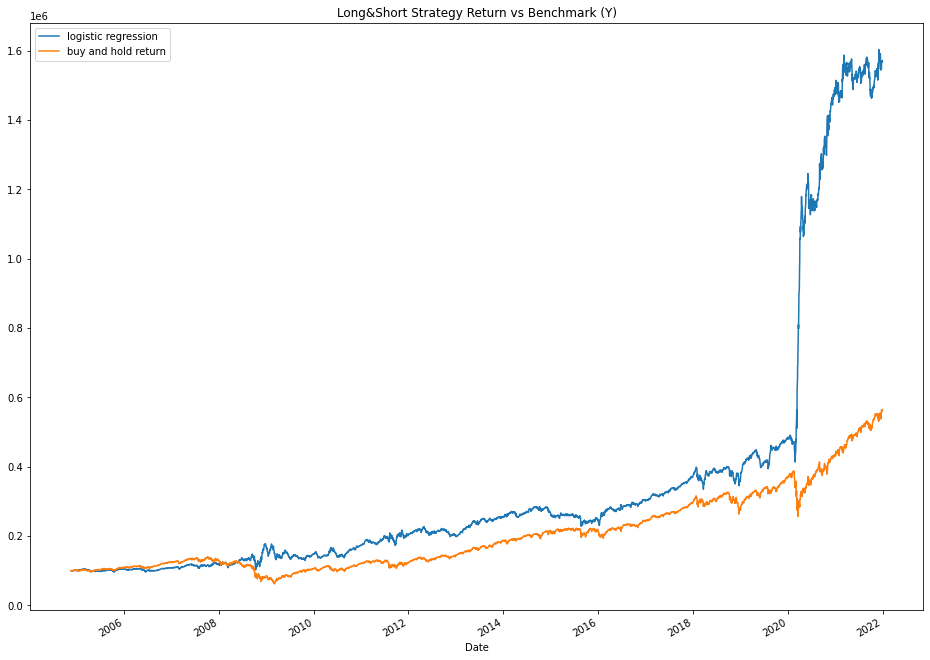

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.421e-01, tolerance: 6.930e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.00213899 -0.00265777 -0.00212581 -0.00209519 -0.00202367 -0.00191939
 -0.00145262 -0.00141907 -0.00134105 -0.00138573]
intercept is 1.992 and coefficients are [-7.34741579 -4.90690795 -6.63089822 -6.63045828 -6.60203716 -6.61121419
 -9.04090655 -9.03906648 -8.9990037  -9.04113096]
Name of features used: ['x22' 'x103' 'x110' 'x123' 'x124' 'x125' 'x138' 'x151' 'x152' 'x194']
 
Accuracy : 0.38390703793027847
 
Precision : 0.4559954428937625
 
Recall : 0.6401439424230307


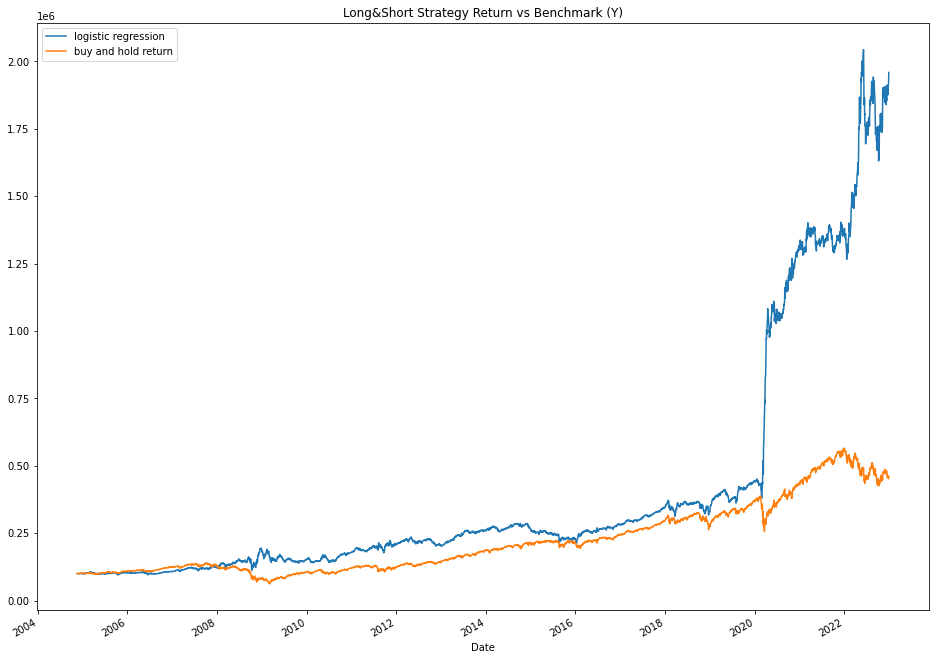

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.496e-01, tolerance: 7.079e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_29579/3779629120.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


intercept is 0.000 and coefficients are [-0.00209075 -0.00260163 -0.00208286 -0.00205219 -0.00198438 -0.0018823
 -0.00142338 -0.0013893  -0.00131554 -0.00135551]
intercept is 2.071 and coefficients are [-7.47367926 -5.00053796 -6.74240417 -6.74054021 -6.71239122 -6.71994601
 -9.16916486 -9.16542008 -9.12589267 -9.16551773]
Name of features used: ['x22' 'x103' 'x110' 'x123' 'x124' 'x125' 'x138' 'x151' 'x152' 'x194']
 
Accuracy : 0.3833088697840218
 
Precision : 0.4550638066793375
 
Recall : 0.6421455938697318


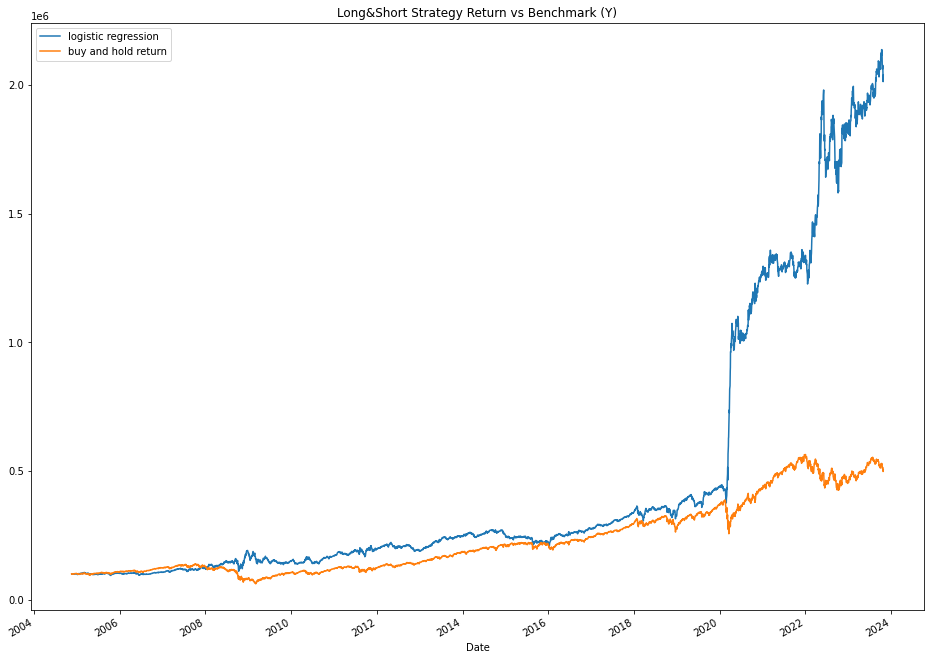

In [93]:
Y_traintest2 = Y_traintest.shift(-1).loc[index_] #1 day look-ahead

params, X_traintest5= fit_and_predict_w_short(df_dict,Y_traintest2,penalty_)



In [94]:
(X_traintest5["strategy_return"].cumsum().apply(np.exp))

Date
2004-11-17          NaN
2004-11-18     1.000000
2004-11-19     1.000000
2004-11-22     1.000000
2004-11-23     1.000000
                ...    
2023-10-23    20.770854
2023-10-24    20.472747
2023-10-25    20.227594
2023-10-26    20.135907
2023-10-27    20.376647
Name: strategy_return, Length: 4769, dtype: float64

In [95]:
X_traintest5.signal.value_counts()

signal
 1    3672
-1    1085
 0      12
Name: count, dtype: int64

# CART (decision tree)

In [96]:
# Model Specification

penalty_ = 0.0

def fit_and_predict_DT(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        DT_model = DecisionTreeRegressor(criterion = "squared_error")

        DT_model.fit(df_dict[year_], Y_traintest_series_fraction)

        DT_pred_train2 = DT_model.predict(df_dict[year_])
        
        train_result = mean_squared_error(DT_pred_train2, Y_traintest_series_fraction)

        DT_pred_train2_df = pd.DataFrame(DT_pred_train2, index = df_dict[year_].index)
        
        print("MSE is {}".format(train_result))

#         params_dict[f"EN_pred_{year_}"] = EN_pred_train2
#         params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
#         params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

#         params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
#         params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
#         params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
#         print("Name of features used: {}".format(elastic_net.feature_names_in_))
#         print(" ")
#         print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
#         print(" ")
#         print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
#         print(" ")
#         print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))

        
        X_traintest3 = df_dict[year_].copy()
        X_traintest3["signal"] = DT_pred_train2_df
        X_traintest3["signal"].iloc[:12] = 0
        X_traintest3["signal"] = (X_traintest3["signal"] > 0).astype(int)
        
        X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "CART (classification)")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Long-only Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

In [97]:
Y_traintest2

Date
2004-11-17   -0.011179
2004-11-18    0.004758
2004-11-19    0.001525
2004-11-22    0.002367
2004-11-23   -0.000760
                ...   
2023-10-23   -0.014456
2023-10-24   -0.012047
2023-10-25   -0.004543
2023-10-26    0.011885
2023-10-27    0.006261
Name: Y_pred, Length: 4769, dtype: float64

MSE is 0.0


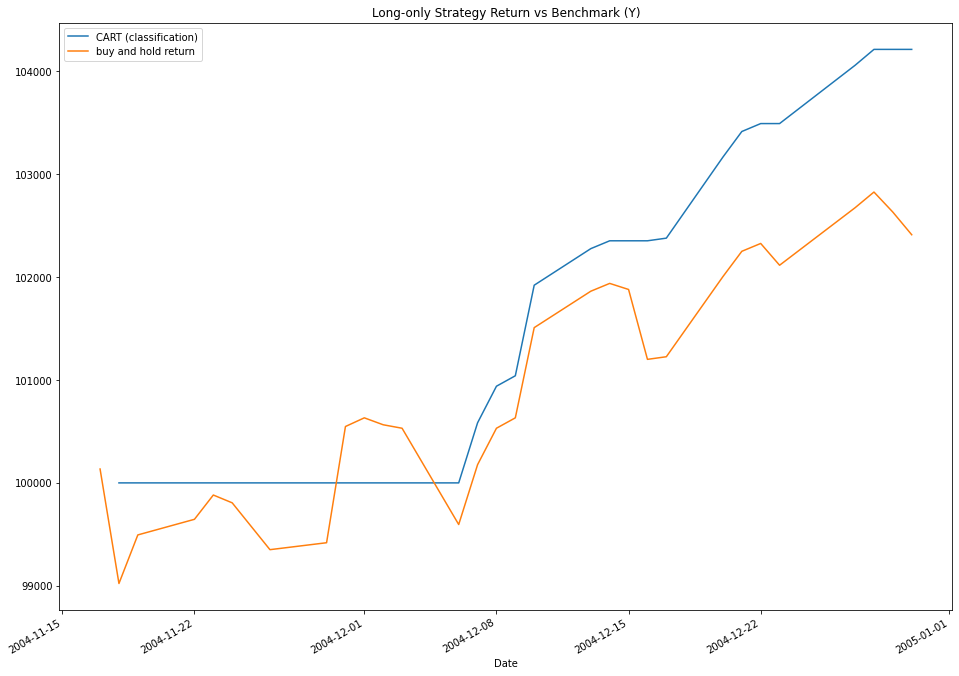

MSE is 0.0


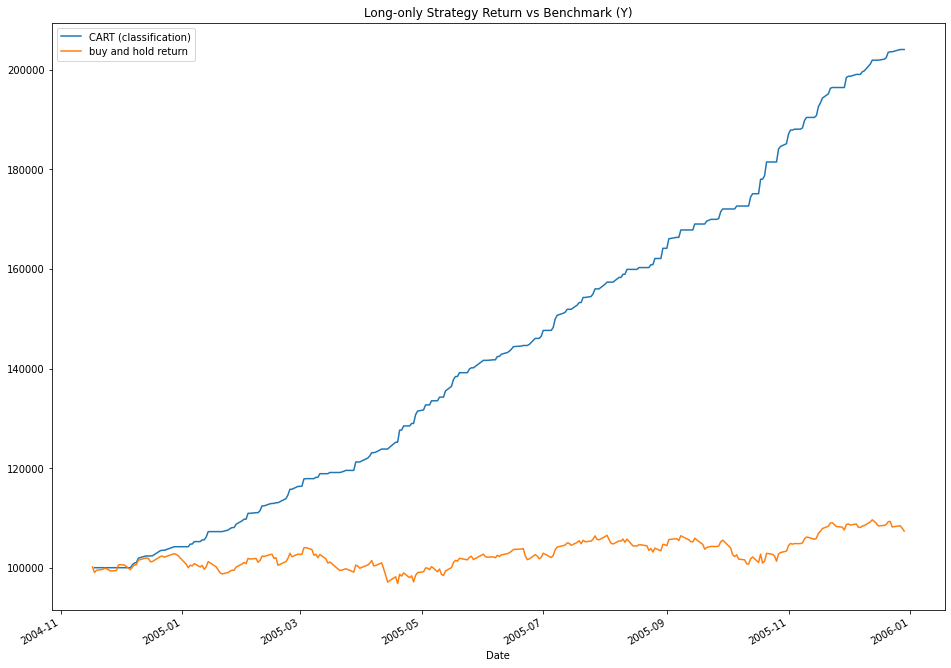

MSE is 0.0


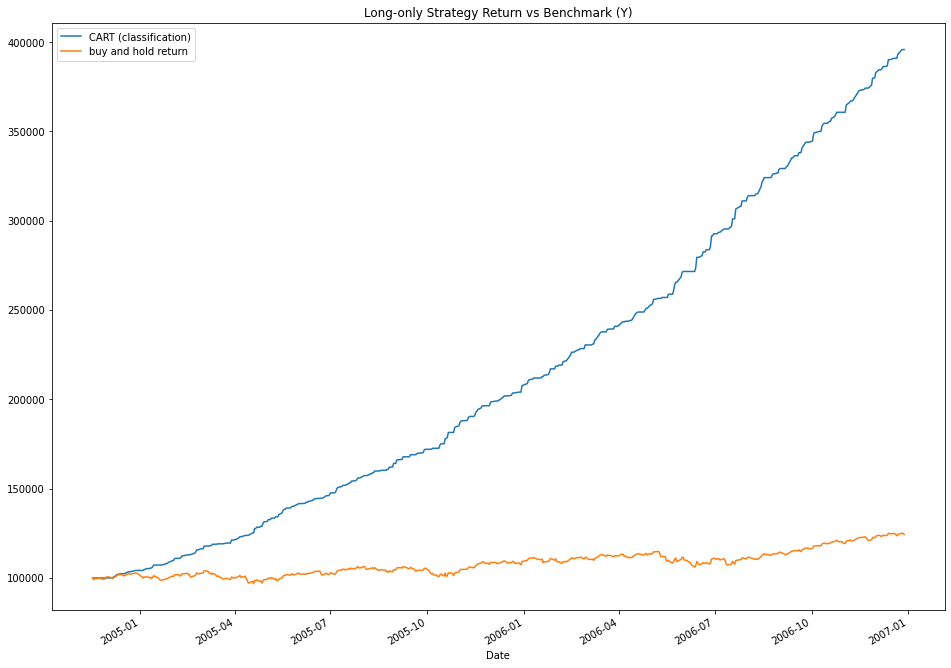

MSE is 0.0


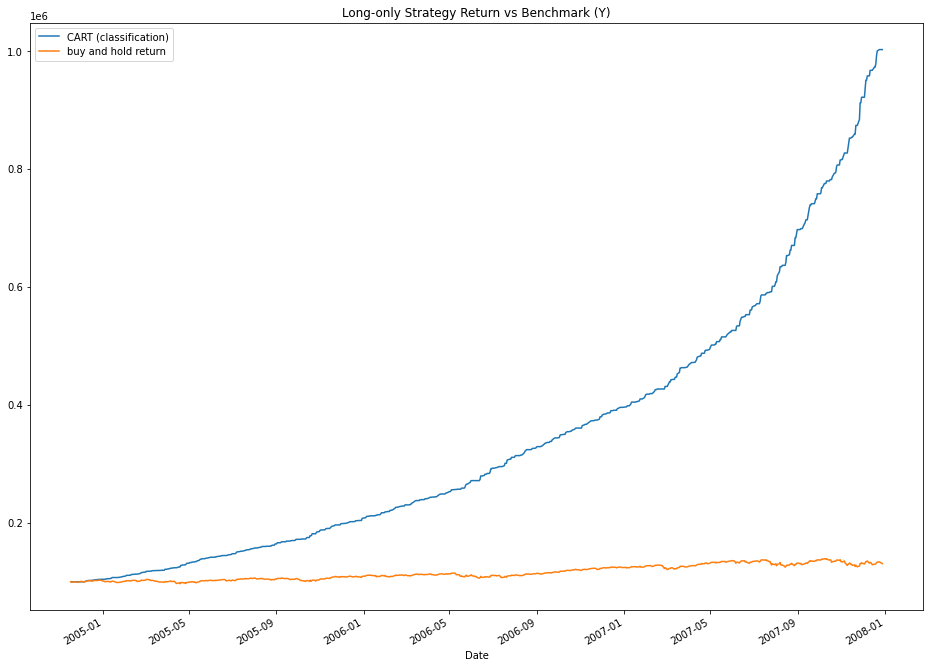

MSE is 0.0


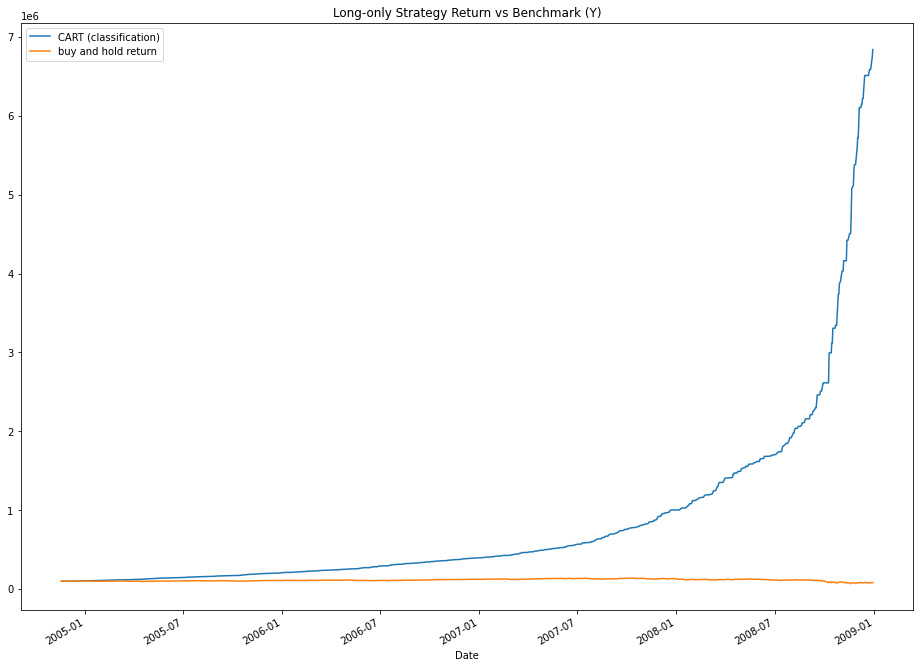

MSE is 0.0


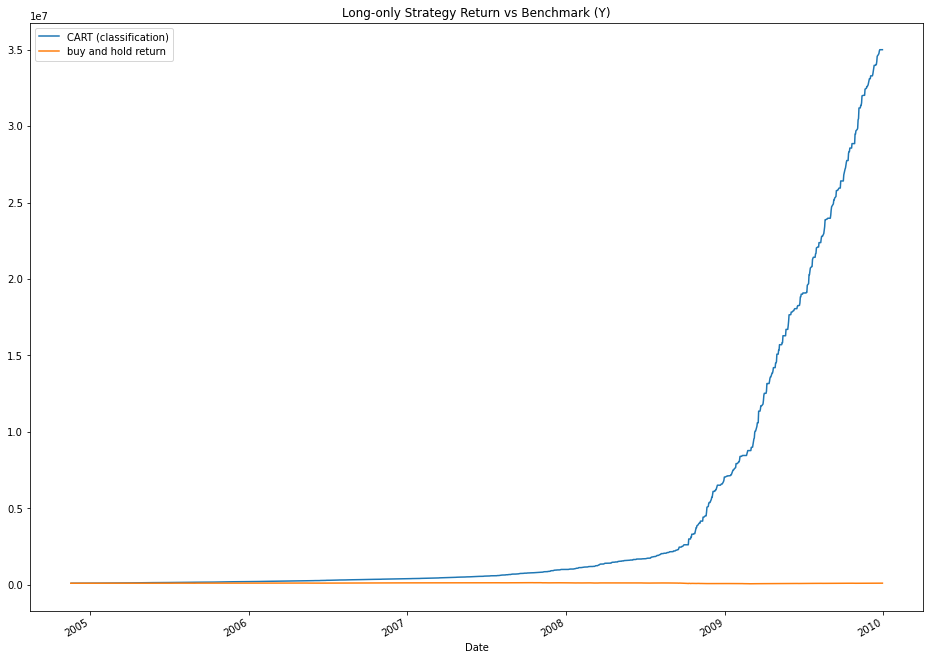

MSE is 0.0


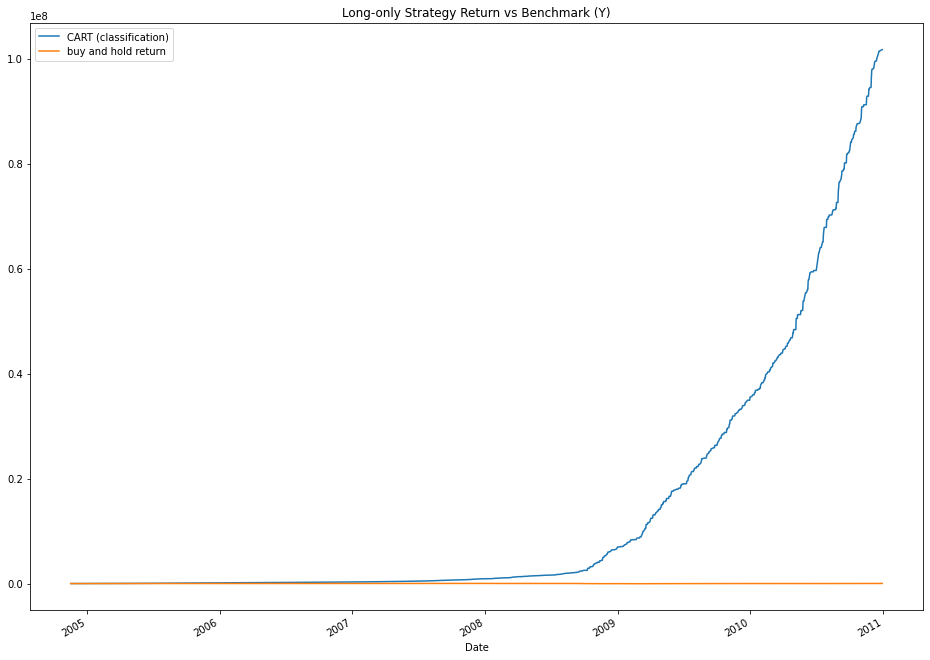

MSE is 0.0


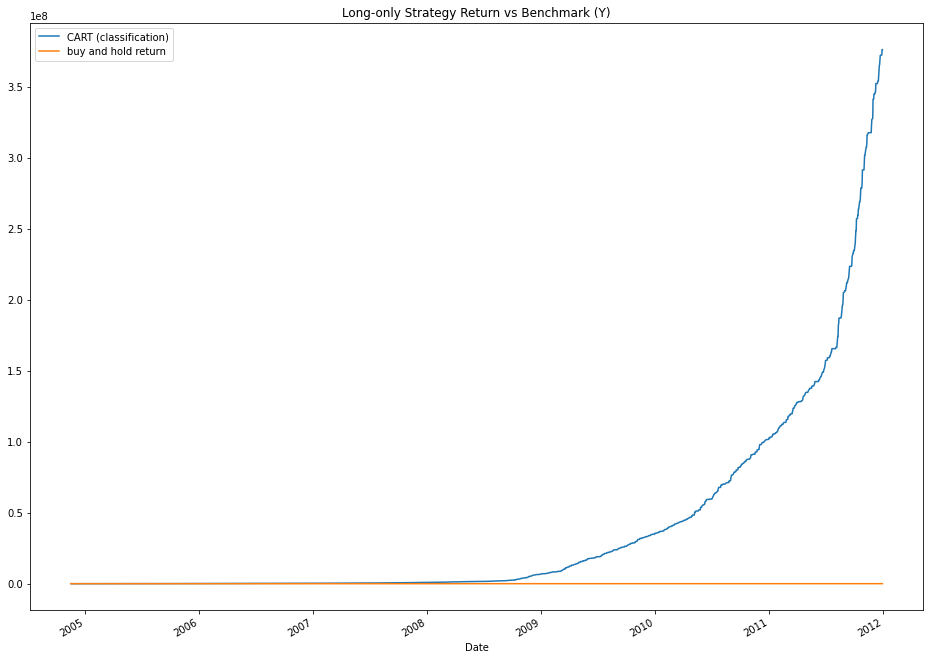

MSE is 0.0


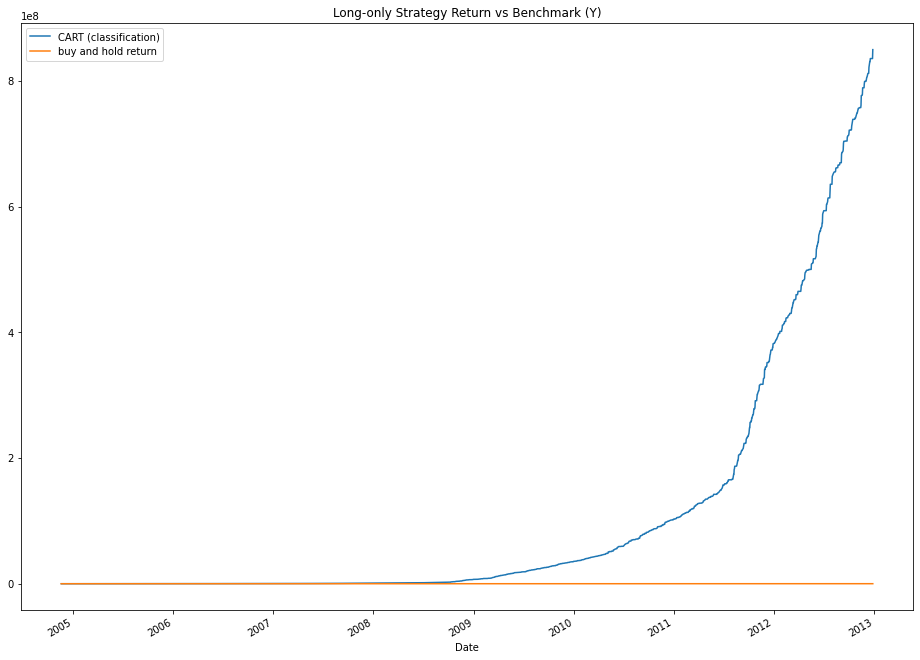

MSE is 0.0


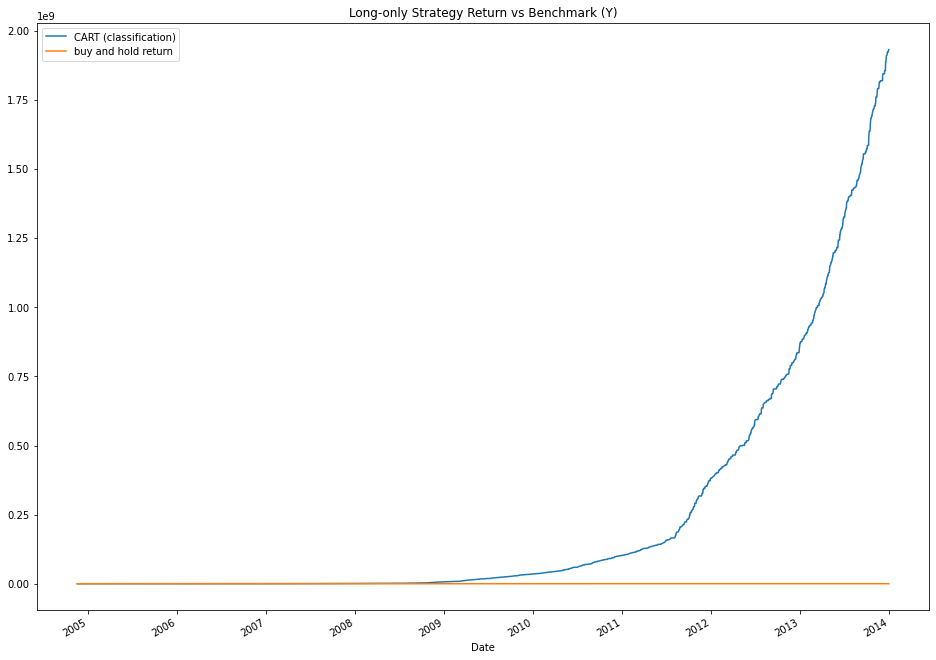

MSE is 0.0


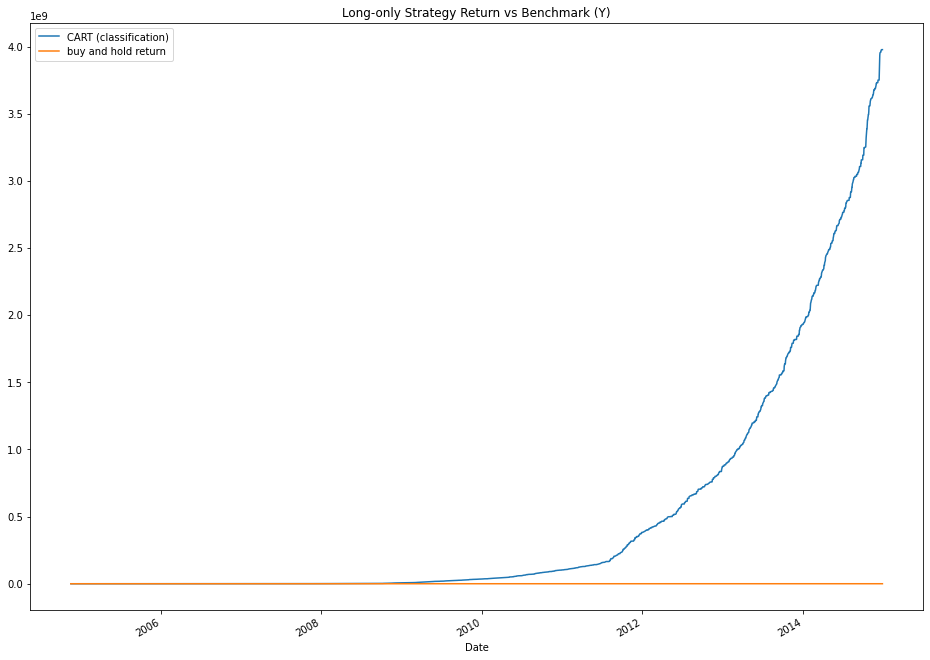

MSE is 0.0


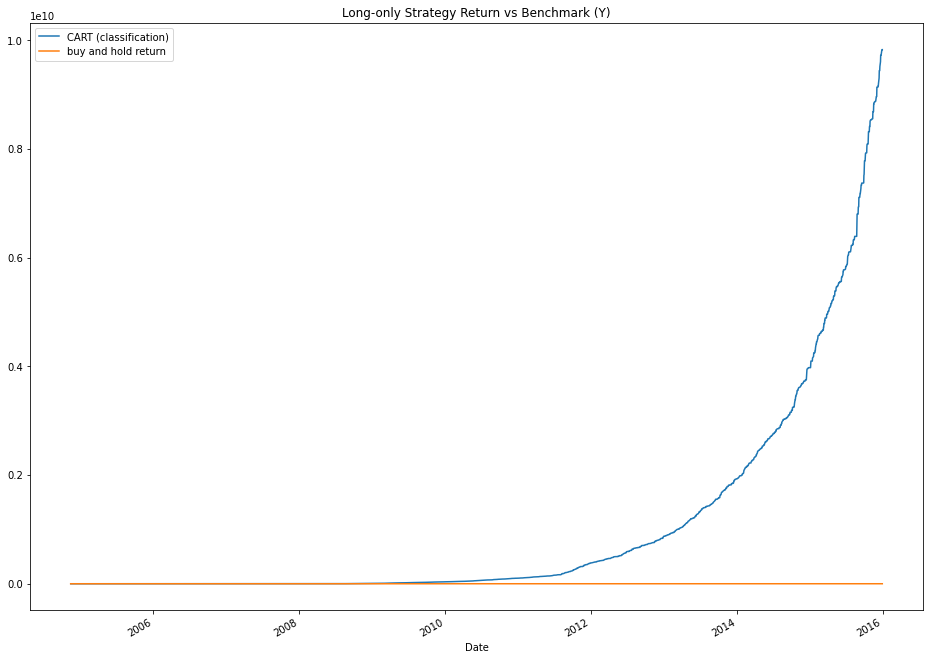

MSE is 0.0


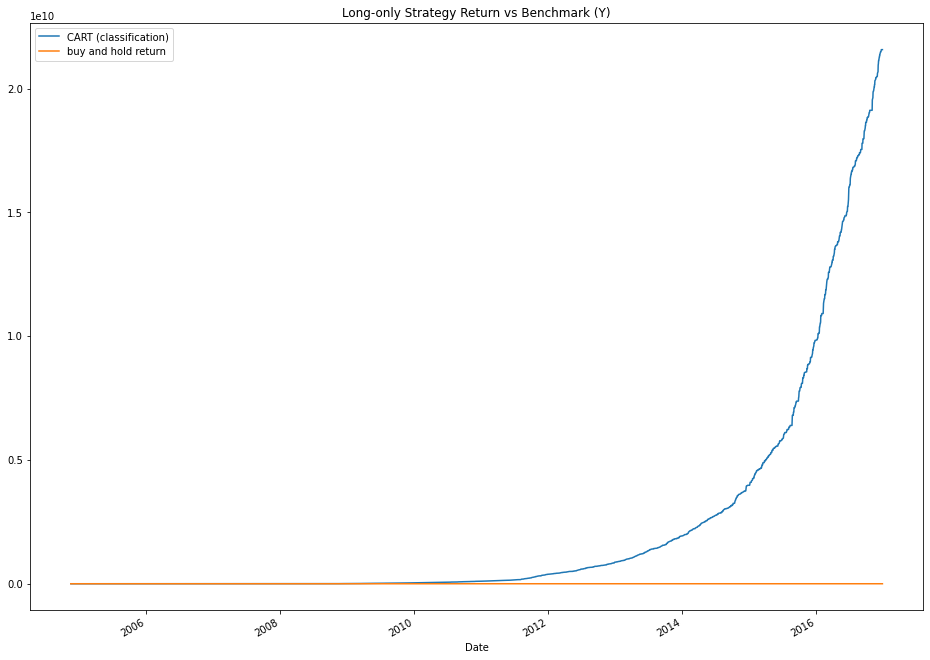

MSE is 0.0


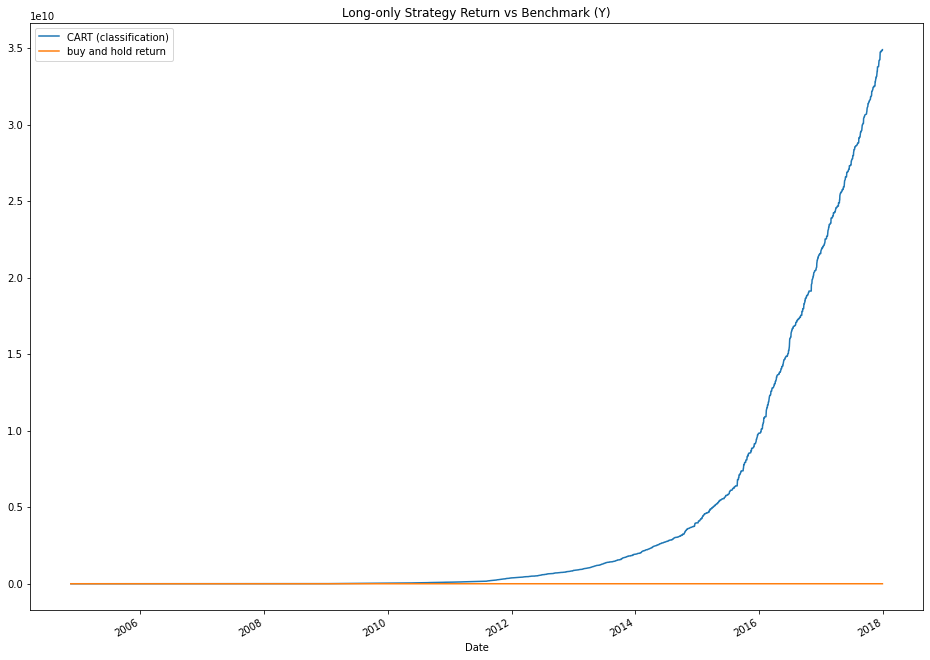

MSE is 0.0


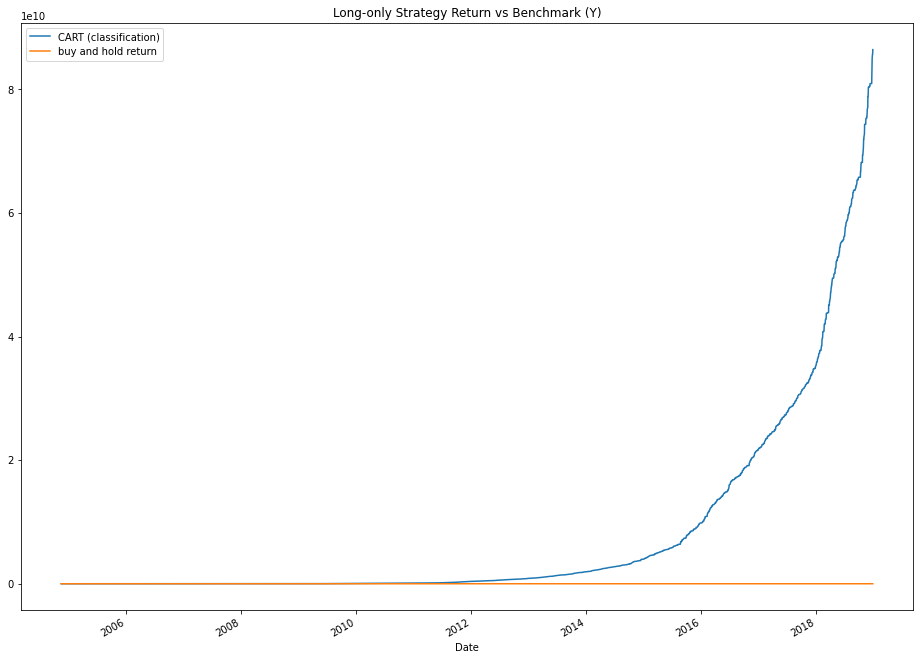

MSE is 0.0


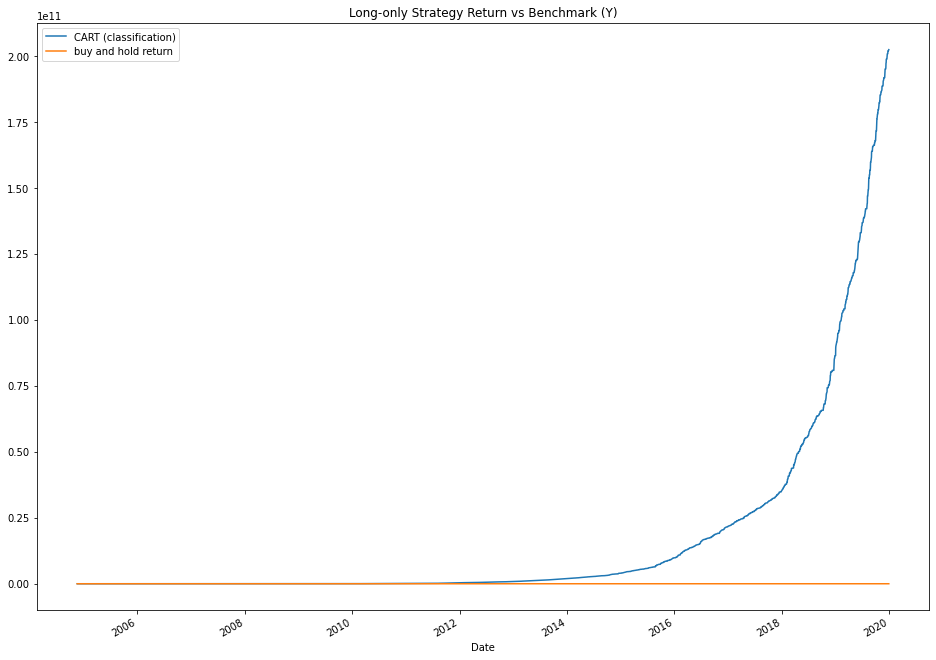

MSE is 0.0


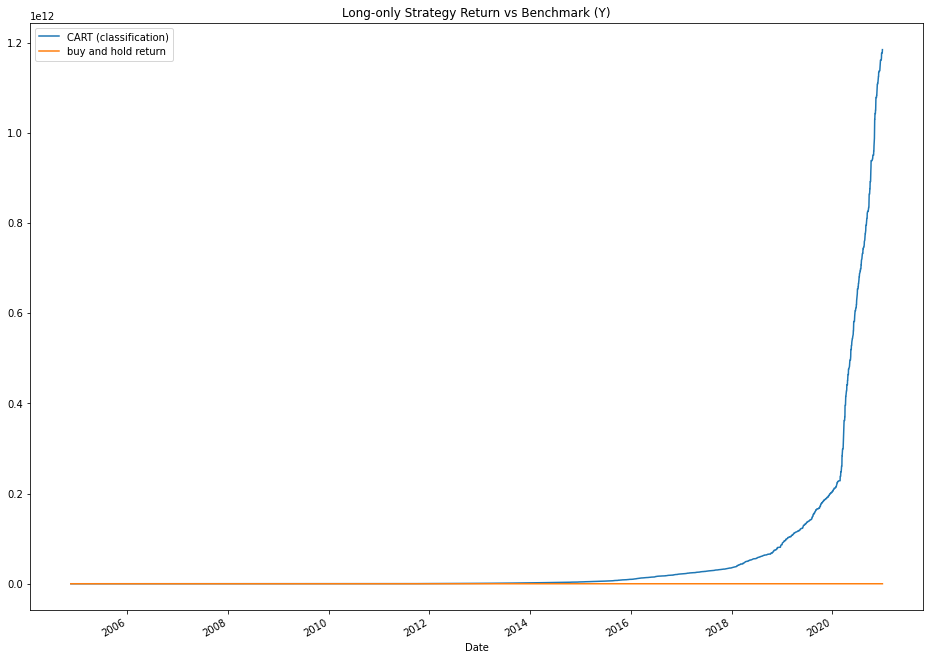

MSE is 0.0


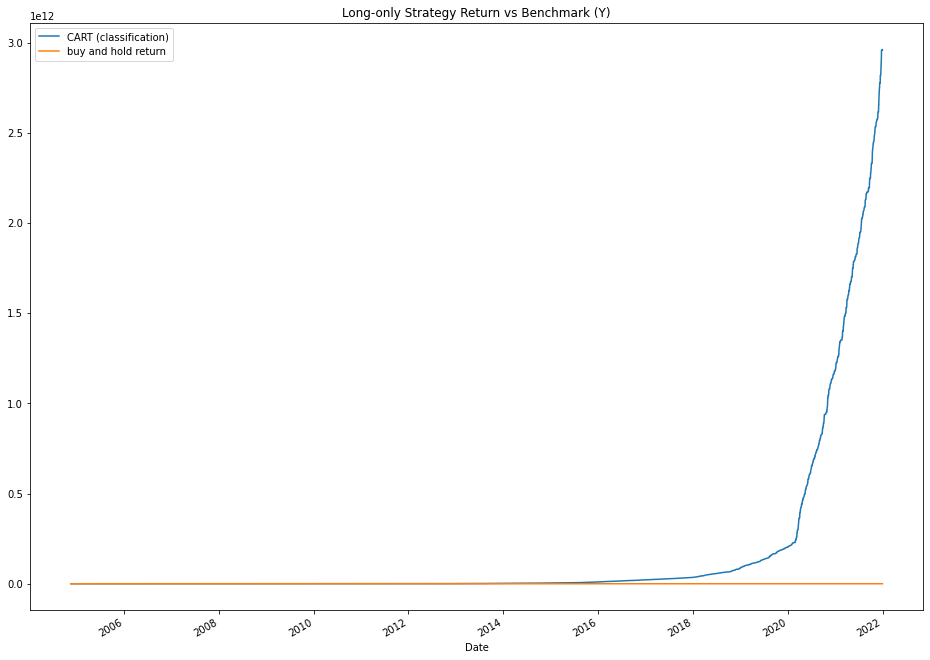

MSE is 0.0


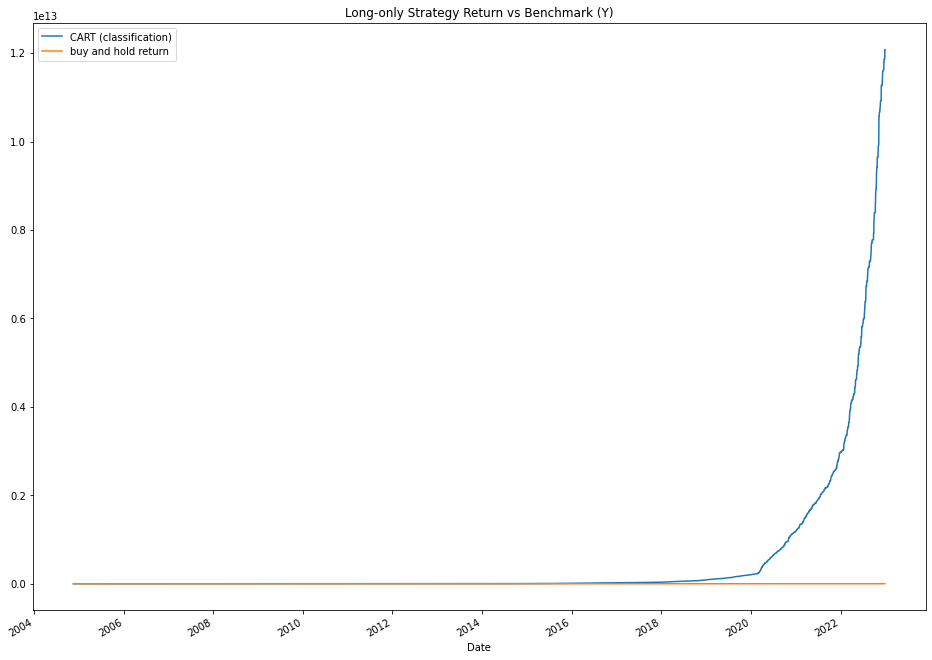

MSE is 0.0


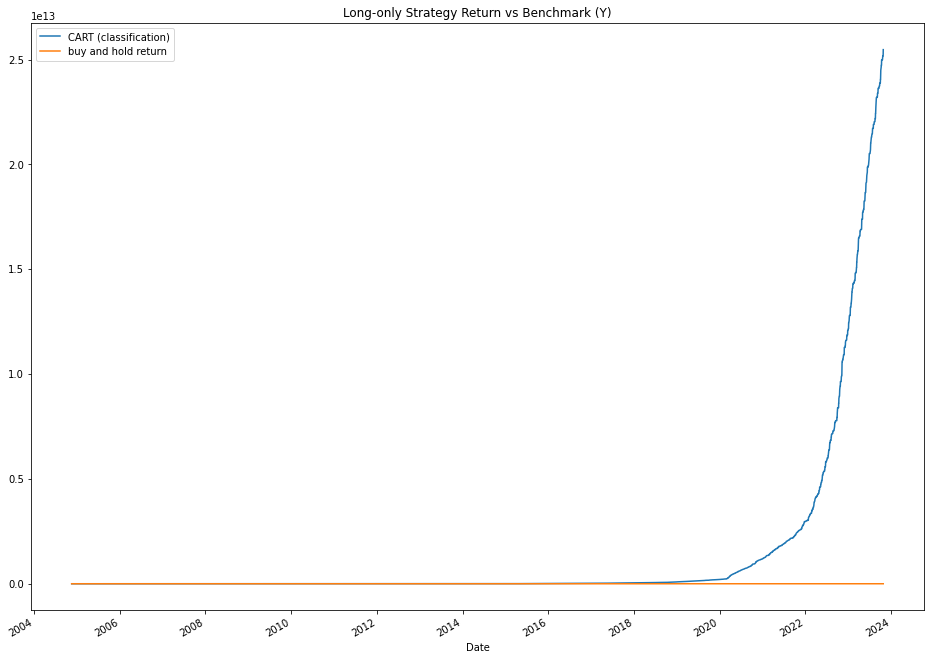

In [98]:
Y_traintest2 = Y_traintest.shift(-1).loc[index_] #1 day look-ahead
dummy_df = fit_and_predict_DT(df_dict,Y_traintest2,penalty_)[1]

<Axes: >

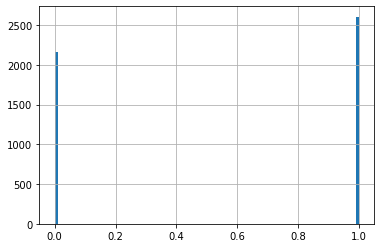

In [99]:
dummy_df["signal"].hist(bins=100)

In [100]:
dummy_df["signal"].value_counts()

signal
1    2604
0    2165
Name: count, dtype: int64

In [101]:
dummy_df["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-17             NaN
2004-11-18    1.000000e+00
2004-11-19    1.000000e+00
2004-11-22    1.000000e+00
2004-11-23    1.000000e+00
                  ...     
2023-10-23    2.517028e+08
2023-10-24    2.517028e+08
2023-10-25    2.517028e+08
2023-10-26    2.517028e+08
2023-10-27    2.547121e+08
Name: strategy_return, Length: 4769, dtype: float64